This notebook extracts the activation patterns of integrator neurons and see if they show any spatial tuning.

In [134]:
import pathlib
import librosa
import numpy as np
import scipy
from tqdm import tqdm
import torch
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import datetime
from loguru import logger

import wandb

import itertools

from utils import compute_frequency_representation
from sensory_preprocessor import SensoryPreprocessor
import json

warnings.filterwarnings(action='ignore')
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 4080 SUPER


### preset params

In [135]:
recording_name = 'Movie_021'
path_to_audio = pathlib.Path(f'./data/processed/{recording_name}/audio/audio.mp3')                  # not used
path_to_video = pathlib.Path(f'./data/processed/{recording_name}/frames')
path_to_aux = pathlib.Path(f'./data/trajectories/3000s_dt_0.02_switch_rect_riab_trajectory.json')
audio, sr = librosa.load(path_to_audio,sr=None, mono=False)
frames = [i for i in path_to_video.glob('*.jpg')]

visual_embedding_dim = 200
img_dim = (160, 120)
grayscale=False
c_channels = 1 if grayscale else 3
tsteps = 10
batch_size = 50
freq_dim = 884
auditory_hidden_dim = 400
auditory_embedding_dim = 200
int_module_hidden_dim = 400
n_rec_layers = 1
aux_dim = 3
rec_interval = 3

sp = SensoryPreprocessor(audio_path=path_to_audio,
                         video_path=path_to_video,
                         aux_path=path_to_aux,
                         tsteps=tsteps,
                         n_frames=150000,
                         grayscale=grayscale)
sp.ttv_split(ratio=(0.8, 0.1, 0.1), seed=seed)

# checkpoints
vision_modules_timestamp = '20240605_222435'
auditory_modules_timestamp = '20240605_213341'
integration_module_timestamp =  '20240606_185420' # '20240608_181529'

### load trained modules

In [136]:
from brain_modules import FFNet, RecIntegrationModule, FFVisualModuleEncoder, FFVisualModuleDecoder, RecIntegrationModule



vision_enc = FFVisualModuleEncoder(visual_embedding_dim=visual_embedding_dim, img_dim=img_dim, grayscale=grayscale, device=device)
vision_dec = FFVisualModuleDecoder(input_dim=visual_embedding_dim, threshold_dims=vision_enc.threshold_dims, grayscale=grayscale, device=device)
vision_enc.load_state_dict(torch.load(f'./trained_models/{recording_name}_vision_enc_{visual_embedding_dim}_{vision_modules_timestamp}.pth'))
vision_dec.load_state_dict(torch.load(f'./trained_models/{recording_name}_vision_dec_{visual_embedding_dim}_{vision_modules_timestamp}.pth'))

auditory_enc = FFNet(input_dim=freq_dim, hidden_dim=auditory_hidden_dim, output_dim=auditory_embedding_dim, device=device)
auditory_dec = FFNet(input_dim=auditory_embedding_dim, hidden_dim=auditory_hidden_dim, output_dim=freq_dim)
auditory_enc.load_state_dict(torch.load(f'./trained_models/{recording_name}_auditory_enc_{auditory_hidden_dim}_{auditory_embedding_dim}_{auditory_modules_timestamp}.pth'))
auditory_dec.load_state_dict(torch.load(f'./trained_models/{recording_name}_auditory_dec_{auditory_hidden_dim}_{auditory_embedding_dim}_{auditory_modules_timestamp}.pth'))
    
integration_module = RecIntegrationModule(auditory_enc=auditory_enc,
                                          auditory_dec=auditory_dec,
                                          vision_enc=vision_enc,
                                          vision_dec=vision_dec,
                                          n_rec_layers=n_rec_layers,
                                          rnn_hidden_dim=int_module_hidden_dim,
                                          integrator_type='rnn',
                                          aux_dim=aux_dim,
                                          use_proj=True,
                                          dropout=0.1,
                                          verbose=True,
                                          device=device).to(device)
integration_module.freeze_auditory_modules()
integration_module.freeze_vision_modules()
integration_module.load_state_dict(torch.load(f'./trained_models/{recording_name}_integration_module_{int_module_hidden_dim}_{n_rec_layers}_{integration_module_timestamp}.pth'))


2024-06-12 18:15:01.730 | DEBUG    | brain_modules:__init__:248 - Using projection layers for auditory and visual modules.
2024-06-12 18:15:01.732 | INFO     | brain_modules:freeze_auditory_modules:281 - Gradient for auditory modules DISABLED.
2024-06-12 18:15:01.732 | INFO     | brain_modules:freeze_vision_modules:265 - Gradient for vision modules DISABLED.


<All keys matched successfully>

### load trajectory and generate hidden states

In [137]:
# let's just use the test set for now
# this method will not work if using LSTM btw

all_test_pos = []
all_test_hd = []
all_test_hidden = []
all_train_pos = []
all_train_hd = []
all_train_hidden = []

# test the integration module
for iter in range(len(sp.test_idxs)// batch_size):
    integration_module.eval()

    with torch.no_grad():
        img, audios, auxs, pos = sp.get_batches(batch_size=batch_size, ttv='te', get_pos=True)

        hd = auxs[:,-1,[3,4]]
        # do not provide hd
        auxs = auxs[:,:,[0,1,2]]
        
        next_img, next_audio, hidden = integration_module(img[:,0:-1:rec_interval,...], audios[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...], return_hidden=True)
        all_test_pos.append(pos)
        all_test_hd.append(hd)
        all_test_hidden.append(hidden.cpu().numpy())

for iter in range(len(sp.train_idxs)// batch_size):
    integration_module.eval()

    with torch.no_grad():
        img, audios, auxs, pos = sp.get_batches(batch_size=batch_size, ttv='tr', get_pos=True)

        hd = auxs[:,-1,[3,4]]
        # do not provide hd
        auxs = auxs[:,:,[0,1,2]]

        next_img, next_audio, hidden = integration_module(img[:,0:-1:rec_interval,...], audios[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...], return_hidden=True)
        all_train_pos.append(pos)
        all_train_hd.append(hd)
        all_train_hidden.append(hidden.cpu().numpy())
all_test_pos = np.vstack(all_test_pos)[:,-1,...].reshape(-1, 2)                 # (n_samples, 2)
all_test_hd = np.vstack(all_test_hd).reshape(-1, 2)                              # (n_samples, hidden_dim)
all_test_hidden = np.vstack(all_test_hidden).reshape(-1, int_module_hidden_dim) # (n_samples, hidden_dim)
all_train_pos = np.vstack(all_train_pos)[:,-1,...].reshape(-1, 2)                 # (n_samples, 2)
all_train_hd = np.vstack(all_train_hd).reshape(-1, 2)                              # (n_samples, hidden_dim)
all_train_hidden = np.vstack(all_train_hidden).reshape(-1, int_module_hidden_dim) # (n_samples, hidden_dim)

KeyboardInterrupt: 

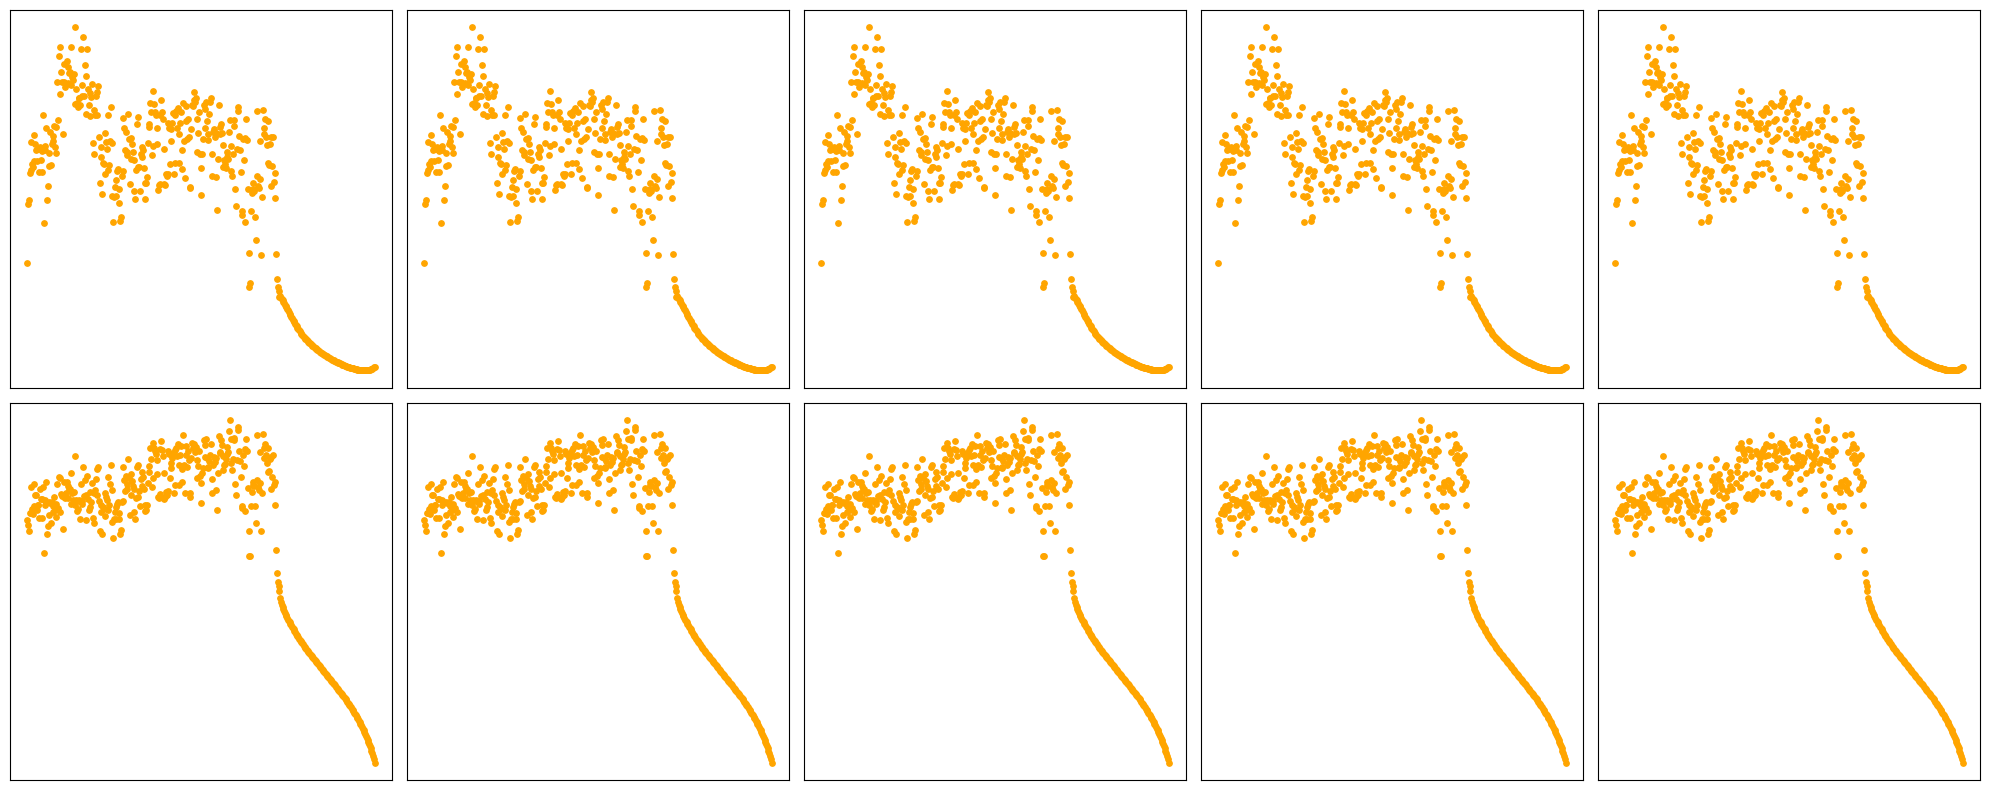

In [158]:
auditory_loss_fn = torch.nn.MSELoss()
n = 5
plt.subplots(2,n, figsize=(20,8))
sp.reset_pointers()
auditory_enc.eval()
auditory_dec.eval()
with torch.no_grad():
    for i in range(n):

        # _ , audio, _ = sp.get_batches(batch_size=batch_size, ttv='te')
        # audio = torch.as_tensor(audio, dtype=torch.float32).view(-1, audio.shape[-1]).to(device)
        # audio_recon = auditory_dec(auditory_enc(audio))
        # loss = auditory_loss_fn(audio_recon, audio)
        # x = np.random.randint(batch_size)
        # audio, audio_recon = audio.cpu().numpy(), audio_recon.cpu().numpy()

        plt.subplot(2,n,i+1)
        # plt.scatter(sp.freqs, audio[x,:freq_dim//2], s=15)
        plt.scatter(sp.freqs, audio_recon[x,:freq_dim//2], s=15, c='orange')
        plt.xticks([])
        plt.yticks([])
        # plt.title(f'L channel') # loss: {str(auditory_loss_fn(torch.as_tensor(audio_recon[x, :freq_dim//2]), torch.as_tensor(audio[x, :freq_dim//2])).numpy())[:5]}')
        plt.subplot(2,n,i+6)
        # plt.scatter(sp.freqs, audio[x,freq_dim//2:], s=15)
        plt.scatter(sp.freqs, audio_recon[x,freq_dim//2:], s=15, c='orange')
        # plt.title(f'R channel ') # loss: {str(auditory_loss_fn(torch.as_tensor(audio_recon[x, freq_dim//2:]), torch.as_tensor(audio[x, freq_dim//2:])).numpy())[:5]}')
        # plt.xlabel('Frequency (Hz)')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
# plt.savefig(f'./report_figs/auditory_reconstructions.png', dpi=200,)

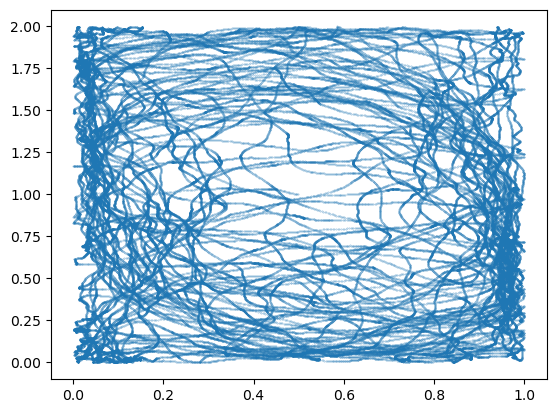

In [5]:
import json

plt.scatter([x['loc'][0] for x in json.loads(path_to_aux.read_text())['pos']], [x['loc'][1] for x in json.loads(path_to_aux.read_text())['pos']], s=0.1, alpha=0.5)

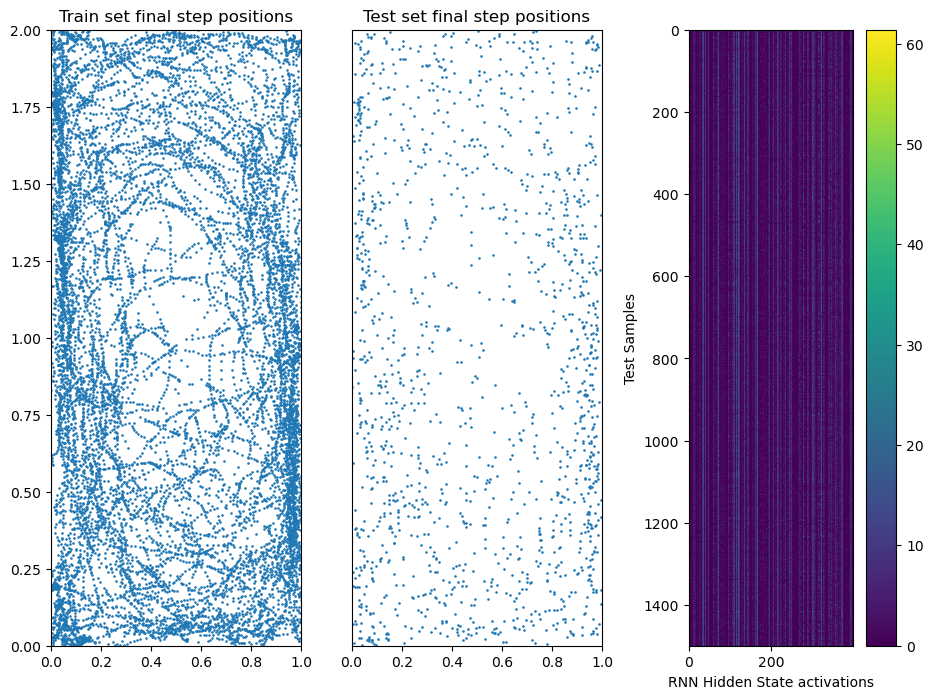

In [6]:
# visualise all sampled positions
plt.subplots(nrows=1, ncols=3, figsize=(11,8), sharey=False)


plt.subplot(131)
plt.scatter(all_train_pos[:,0], all_train_pos[:,1], s=0.75)
plt.xlim(0,1)
plt.ylim(0,2)
plt.title('Train set final step positions')
plt.subplot(132)

plt.scatter(all_test_pos[:,0], all_test_pos[:,1], s=0.75)
plt.xlim(0,1)
plt.ylim(0,2)
plt.yticks([])
plt.title('Test set final step positions')

plt.subplot(133)
plt.imshow(all_test_hidden)
plt.xlabel('RNN Hidden State activations')
plt.ylabel('Test Samples')
plt.colorbar()
plt.show()

### linear decoding of positions in the test set

In [8]:
# Step 2: Train a Linear Decoder
from sklearn.linear_model import LinearRegression
decoder = LinearRegression()
decoder.fit(all_train_hidden, all_train_pos)

# Predict positions from hidden states
decoded_positions = decoder.predict(all_test_hidden)

from sklearn.metrics import explained_variance_score
explained_variance = explained_variance_score(all_test_pos, decoded_positions)
explained_variance

0.6331055133261323

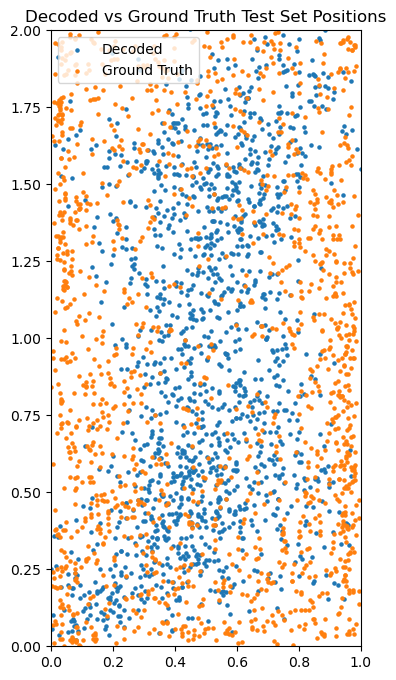

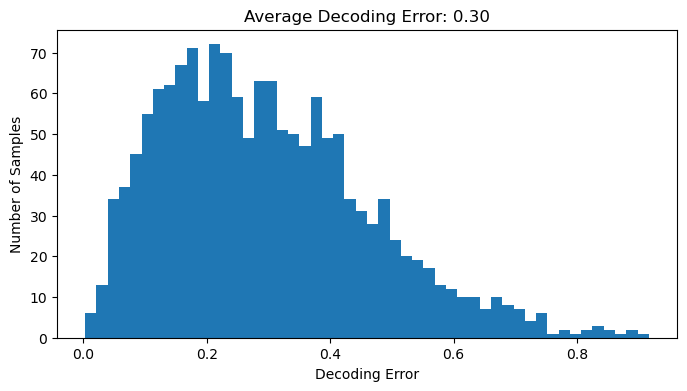

In [9]:
decoding_error = np.linalg.norm(all_test_pos - decoded_positions, axis=1)
plt.figure(figsize=(4,8))
plt.xlim([0,1])
plt.ylim([0,2])
plt.scatter(decoded_positions[:, 0], decoded_positions[:, 1],  s=5, label='Decoded')
plt.scatter(all_test_pos[:, 0], all_test_pos[:, 1], s=5, label='Ground Truth')
plt.legend()
plt.title('Decoded vs Ground Truth Test Set Positions')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(decoding_error, bins=50)
plt.xlabel('Decoding Error')
plt.ylabel('Number of Samples')
plt.title('Average Decoding Error: {:.2f}'.format(np.mean(decoding_error)))
plt.show()

In [17]:
explained_variance = explained_variance_score(all_test_pos, decoded_positions)
# mse = mean_squared_error(all_test_pos, decoded_positions)
print(f'Explained variance (test set): {explained_variance:.4f}')
# print(f'Mean squared error (test set): {mse:.4f}')

Explained variance (test set): 0.6331


### positional tuning

In [14]:
import seaborn as sns
# Step 4: Calculate Tuning Curves
grid_size = (10, 20)  # Assuming a 10x10 grid world
num_neurons = 400

# Initialize arrays to hold tuning curves
tuning_curves = np.zeros((num_neurons, grid_size[0], grid_size[1]))

# Aggregate neuron activity by spatial position
for i in range(all_train_pos.shape[0]):
    x, y = int(all_train_pos[i, 0] * (grid_size[0] )), int(all_train_pos[i, 1]/2 * (grid_size[1] ))
    tuning_curves[:, x, y] += all_train_hidden[i]

# Average activity by position
position_counts = np.zeros(grid_size)
for x, y in all_train_pos:
    y = y / 2
    x, y = int(x * (grid_size[0] )), int(y * (grid_size[1] ))
    position_counts[x, y] += 1

# Avoid division by zero
position_counts[position_counts == 0] = 1
tuning_curves /= position_counts

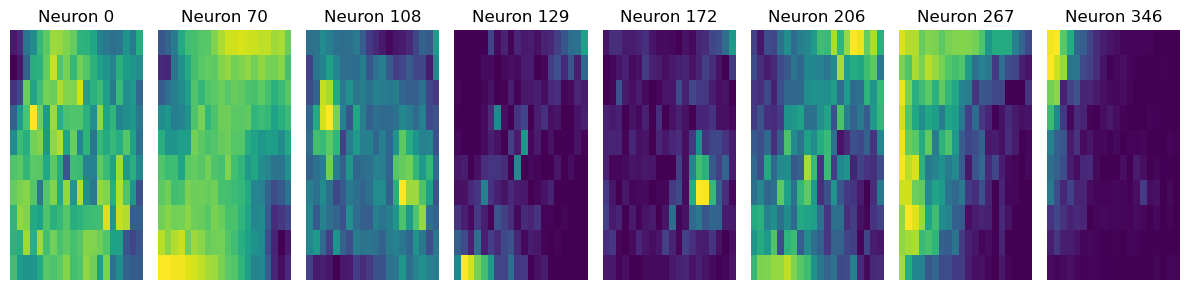

In [42]:
selected_neuron_idxs = [0, 70, 108, 129, 172, 206, 267, 346] # all over, diagonal, two spot, pc, wall, corner

plt.figure(figsize=(12, 3))
for i, idx in enumerate(selected_neuron_idxs):
    plt.subplot(1, 8, i + 1)
    sns.heatmap(tuning_curves[idx, :, :], cmap='viridis', cbar=False)
    plt.title(f'Neuron {idx}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('./report_figs/selected_positional_tuning.png', dpi=200)
plt.show()

In [43]:
spatially_tuned_neurons = []
for i in range(num_neurons):
    if tuning_curves[i].sum() > 0: spatially_tuned_neurons.append(i)

100it [00:57,  1.74it/s]


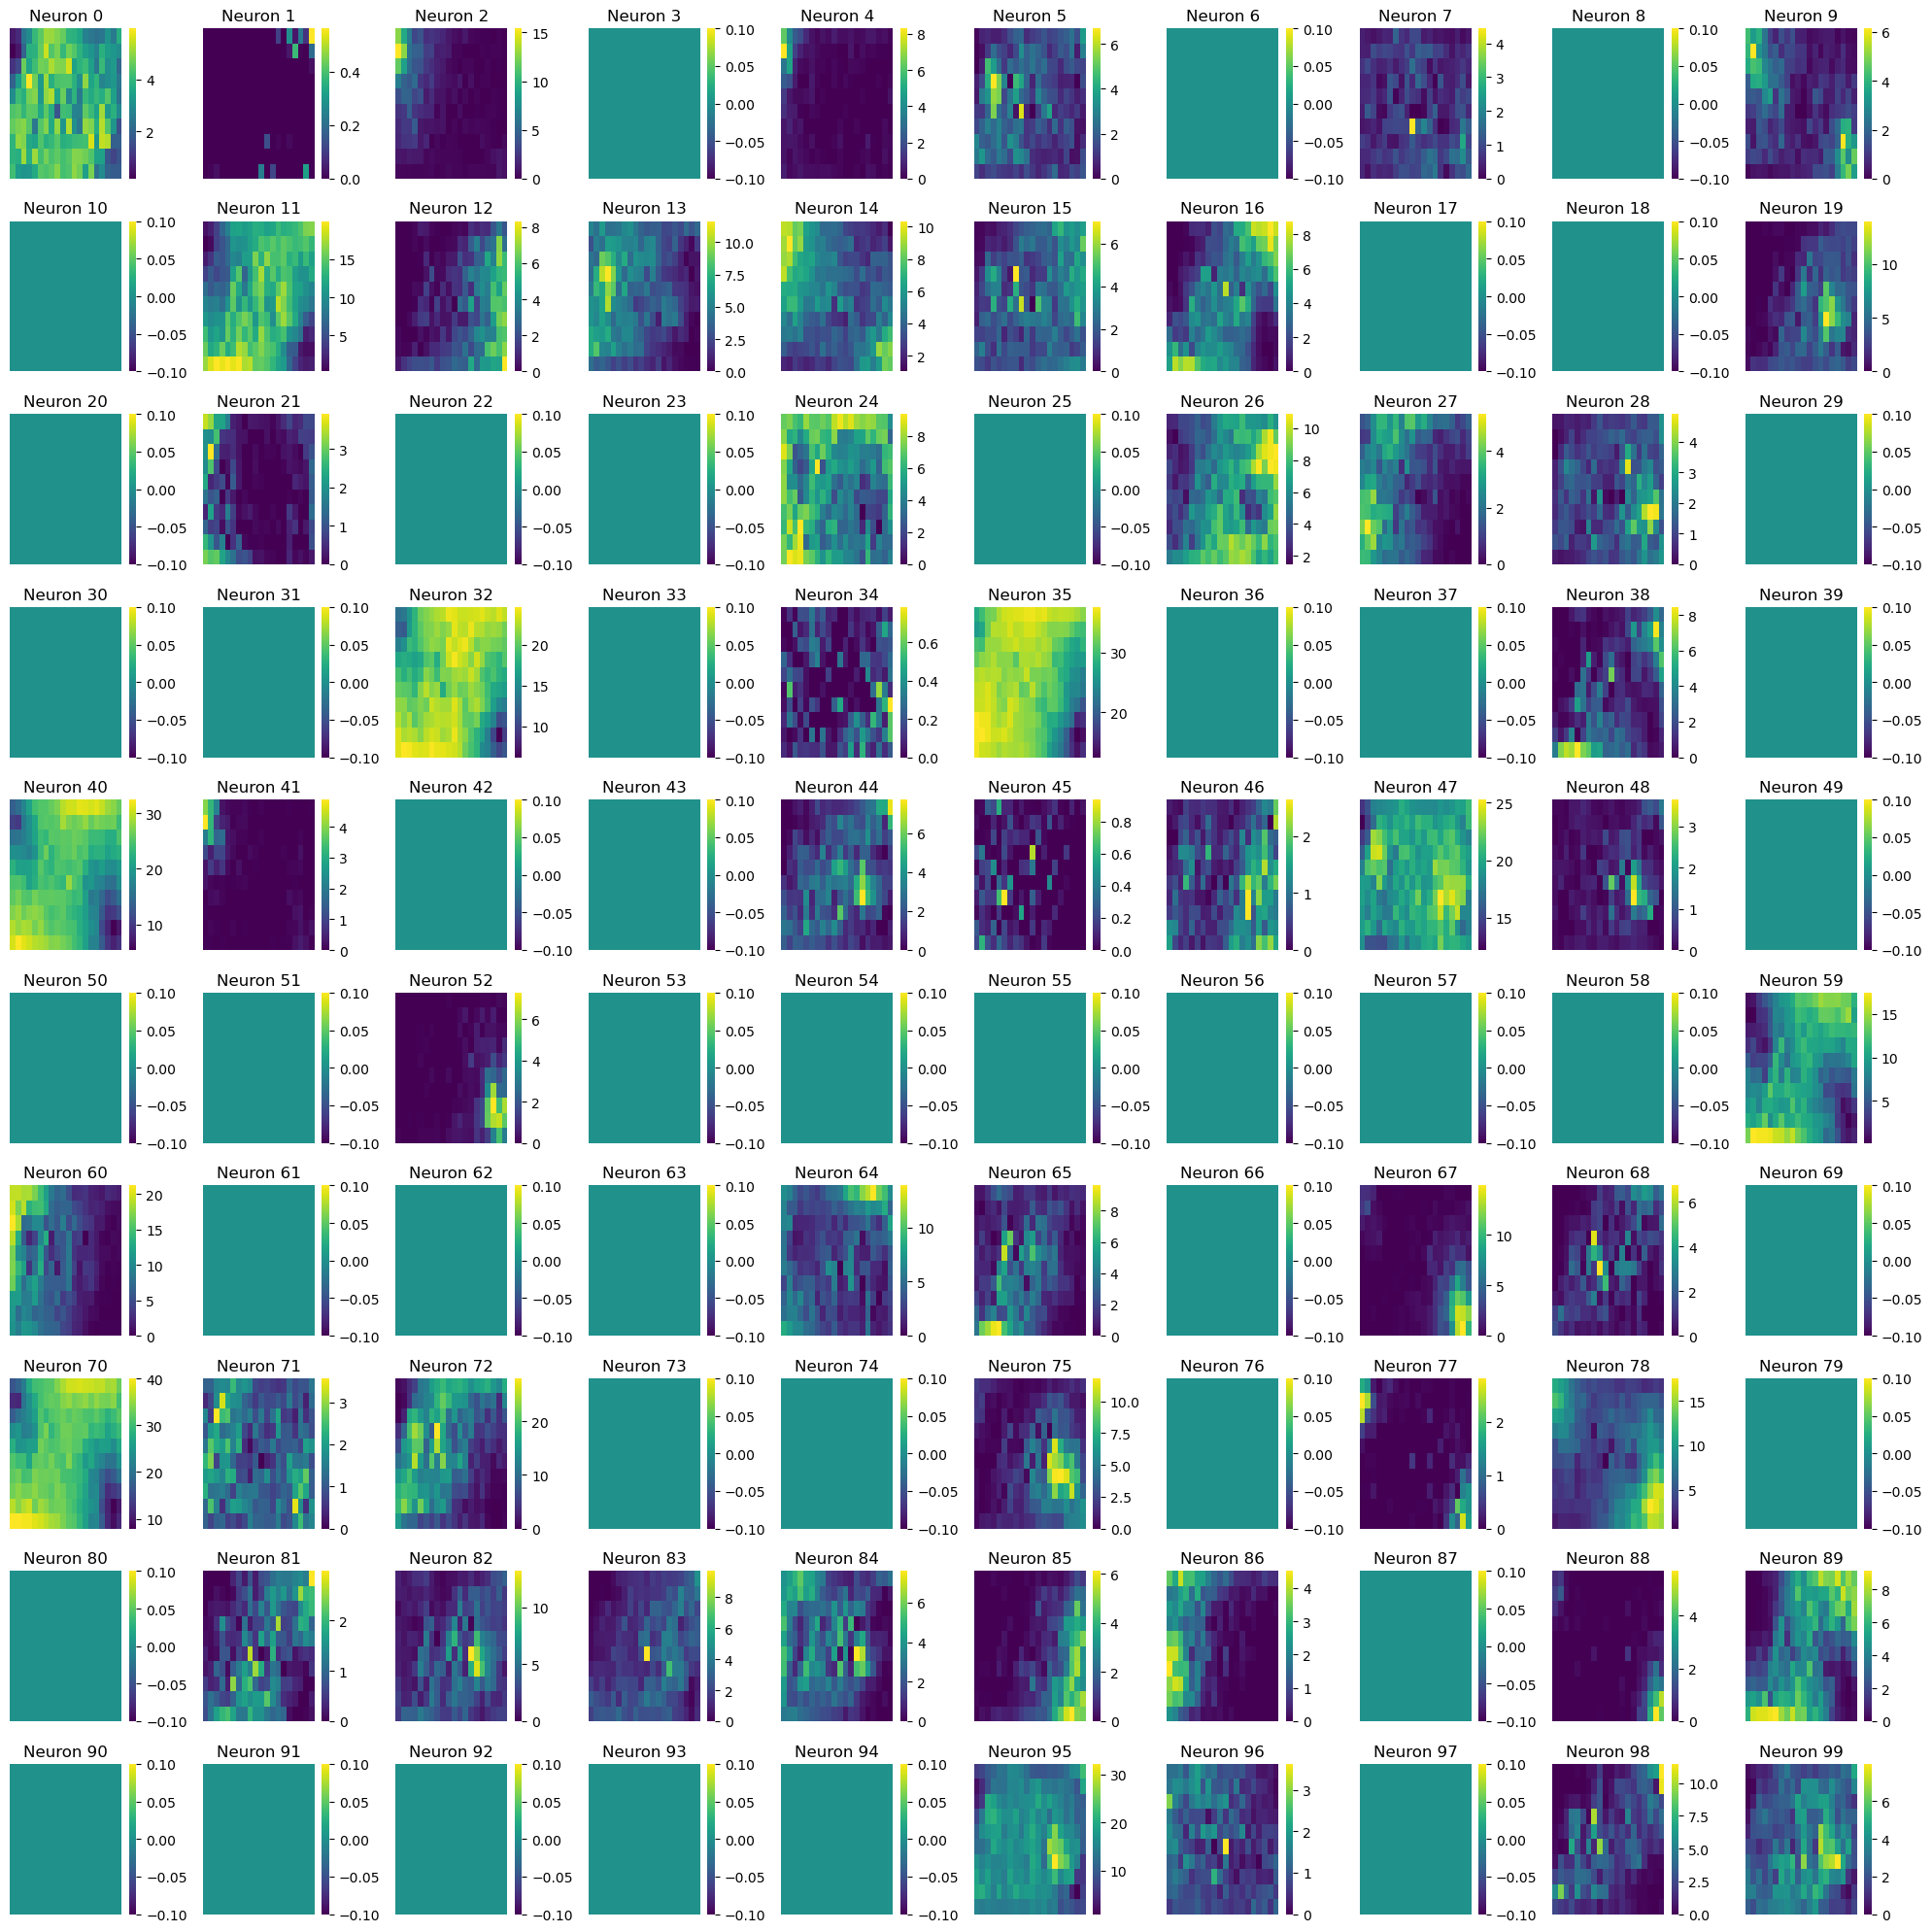

100it [00:57,  1.75it/s]


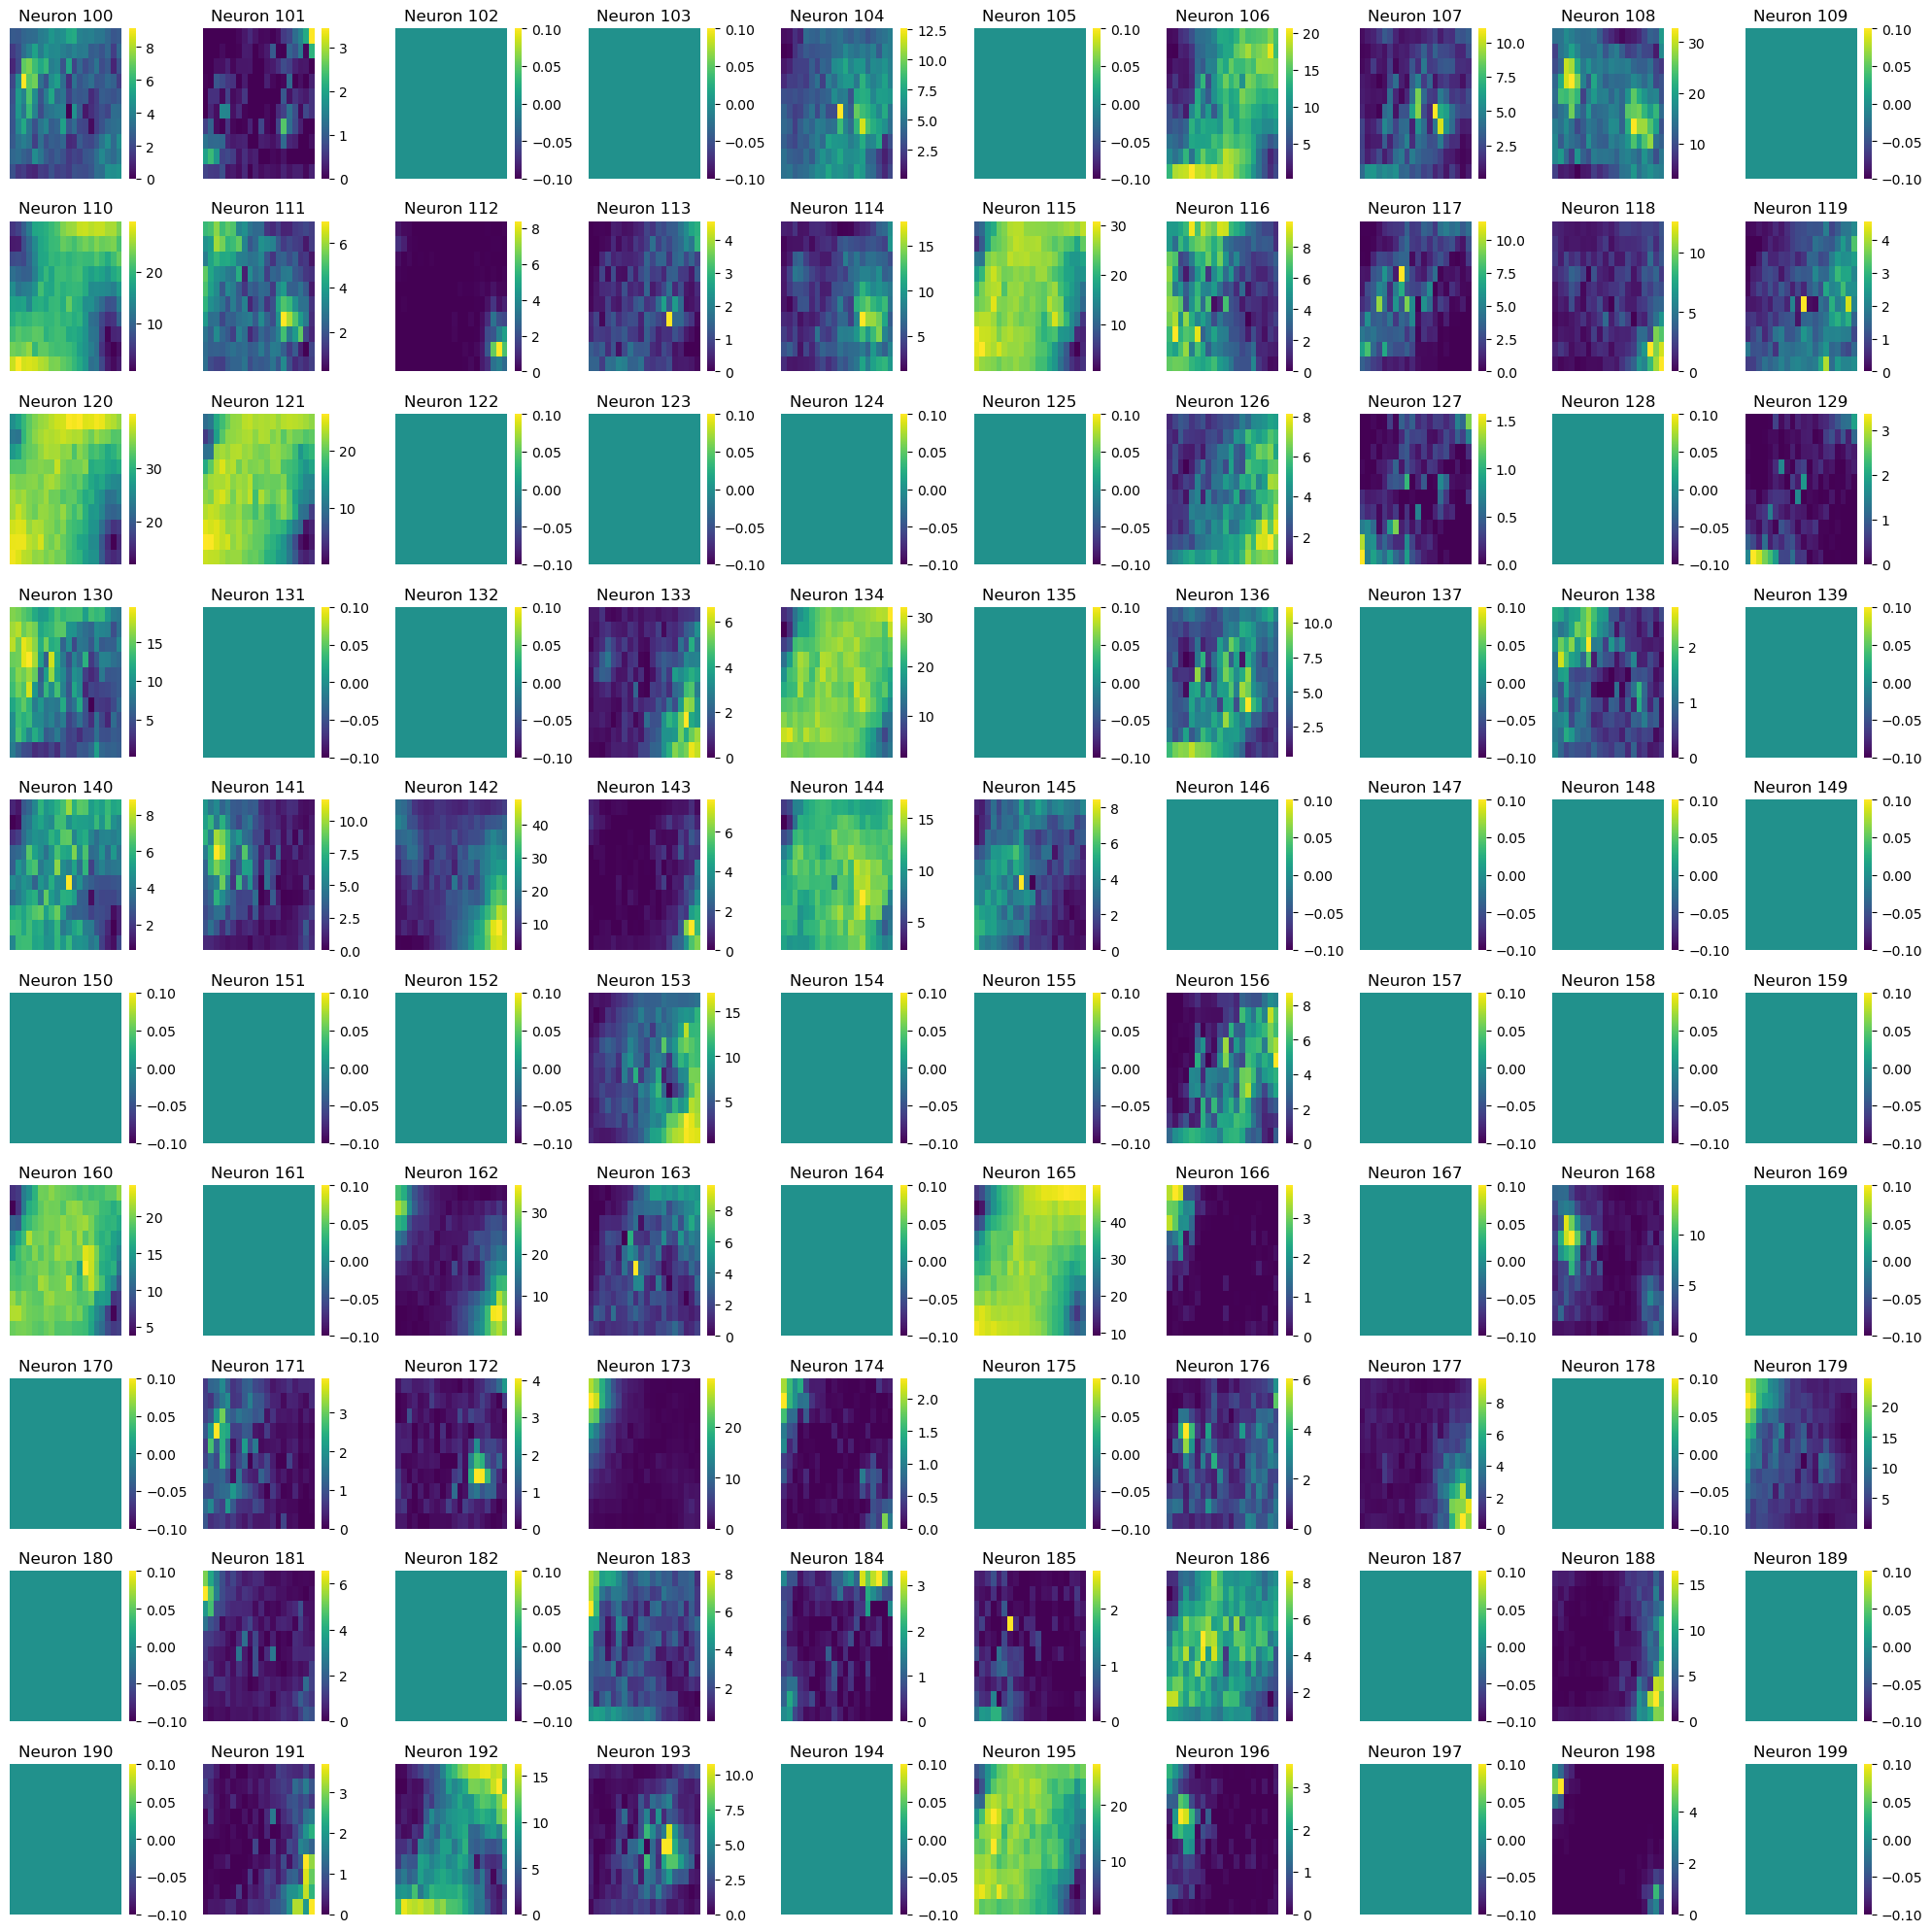

In [23]:
# Step 5: Visualize Tuning Curves for a Few Neurons
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in tqdm(enumerate(axes.flat)):
    sns.heatmap(tuning_curves[i], ax=ax, cmap='viridis')
    ax.set_title(f'Neuron {i}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in tqdm(enumerate(axes.flat)):
    sns.heatmap(tuning_curves[i+100], ax=ax, cmap='viridis')
    ax.set_title(f'Neuron {i+100}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

100it [00:54,  1.83it/s]


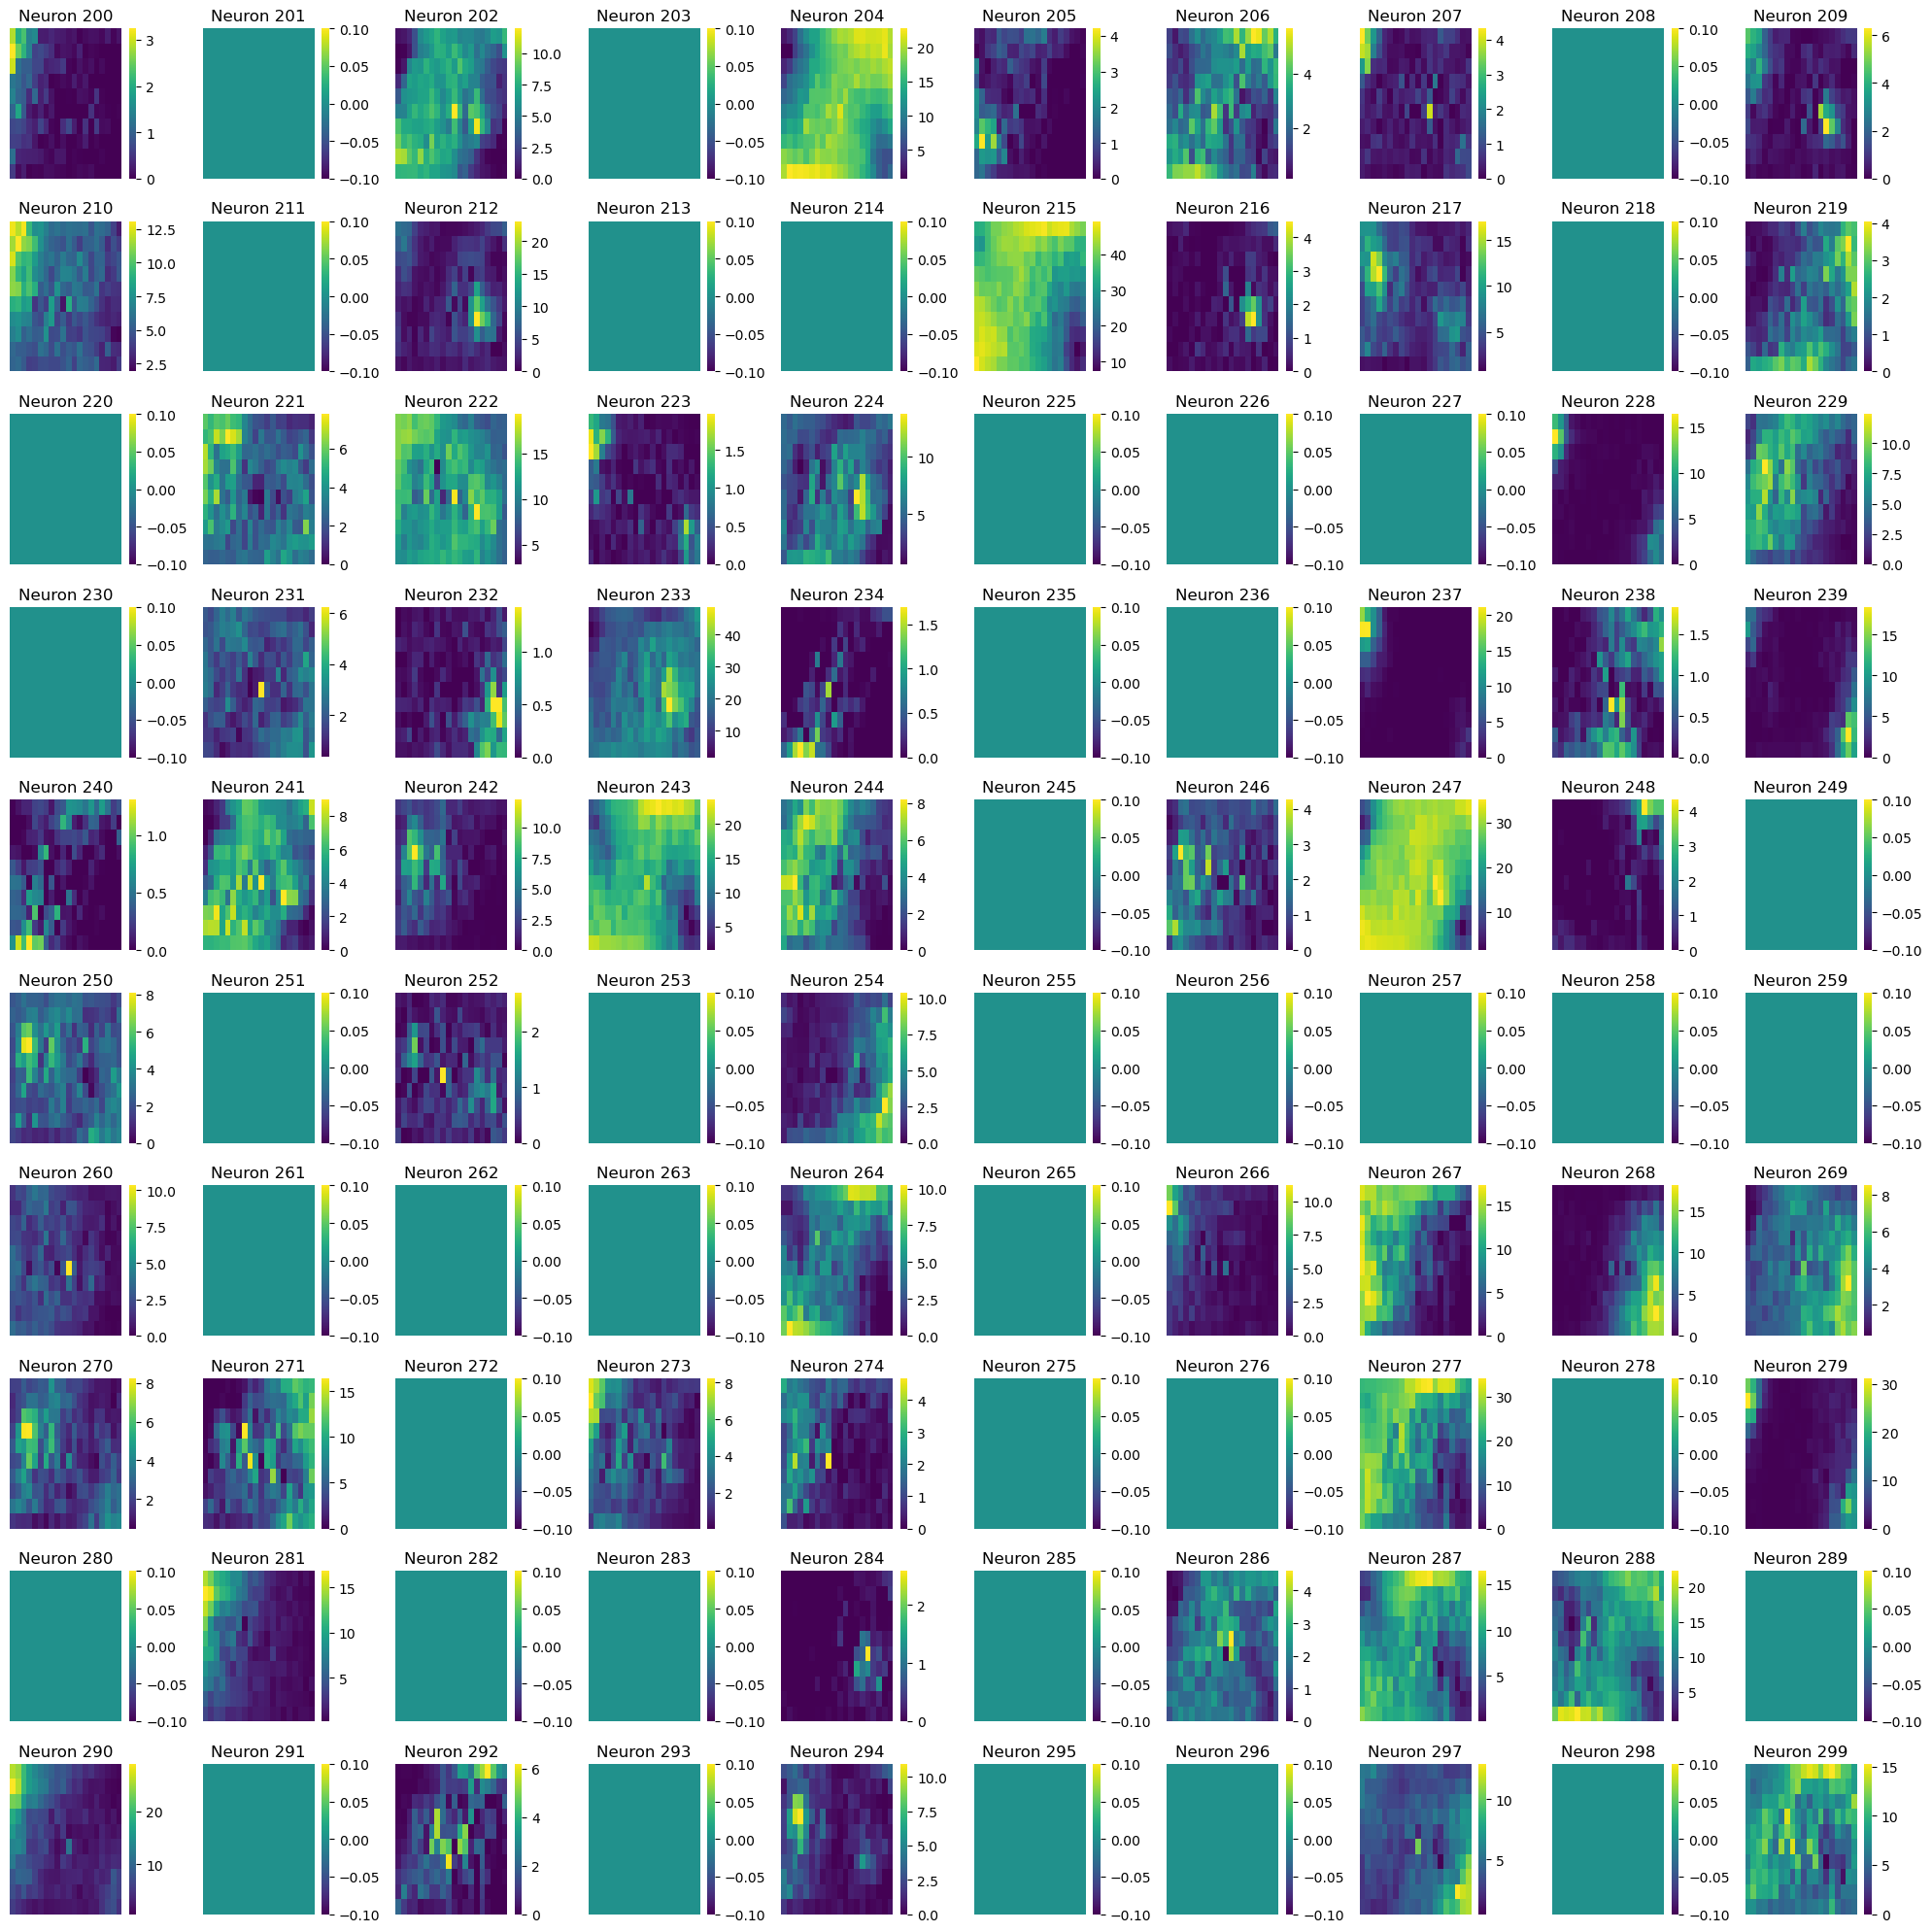

100it [00:55,  1.80it/s]


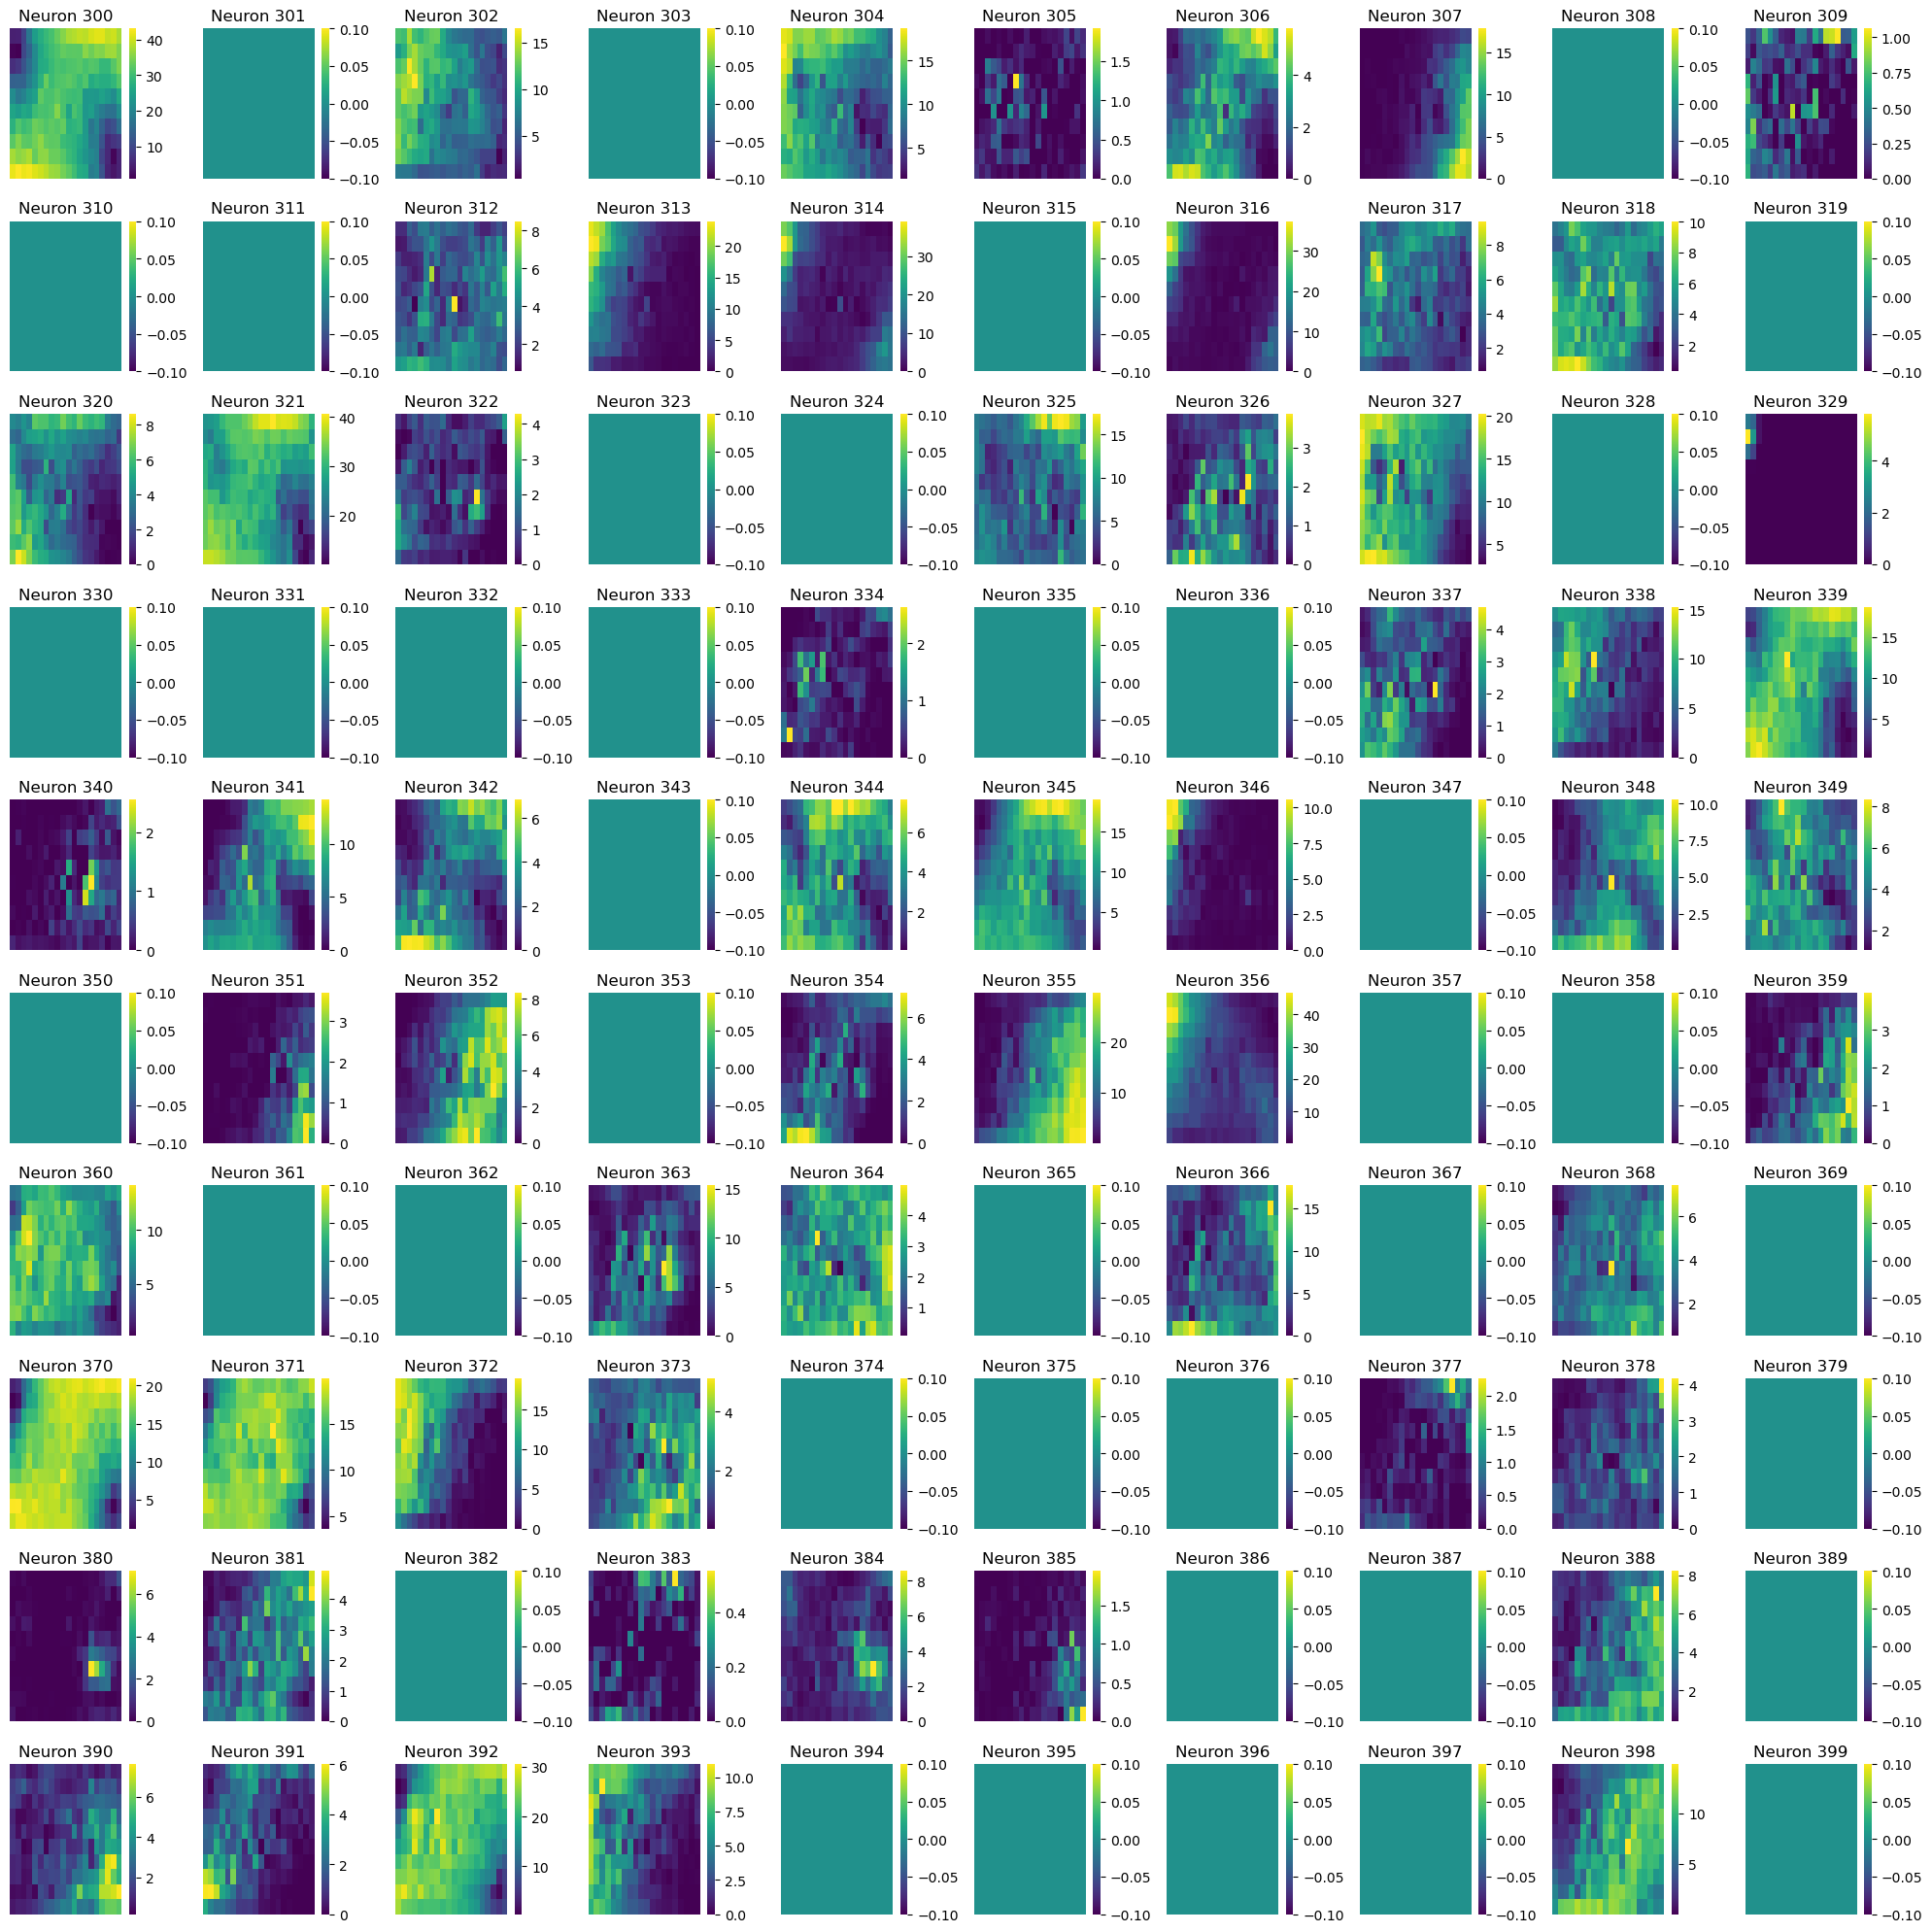

In [25]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in tqdm(enumerate(axes.flat)):
    sns.heatmap(tuning_curves[i+200], ax=ax, cmap='viridis')
    ax.set_title(f'Neuron {i+200}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in tqdm(enumerate(axes.flat)):
    sns.heatmap(tuning_curves[i+300], ax=ax, cmap='viridis')
    ax.set_title(f'Neuron {i+300}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

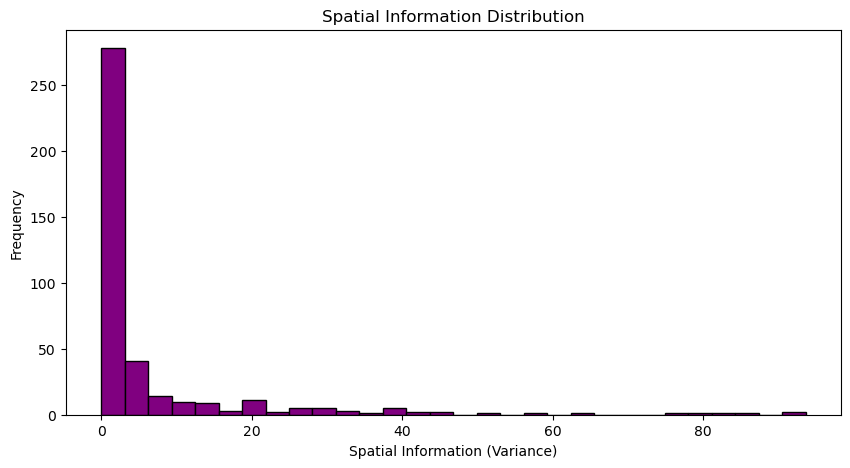

In [45]:
# Step 6: Quantify Spatial Information
# Calculate explained variance for each neuron
spatial_information = np.var(tuning_curves, axis=(1, 2))

# Plot distribution of spatial information
plt.figure(figsize=(10, 5))
plt.hist(spatial_information, bins=30, color='purple', edgecolor='black')
plt.title('Spatial Information Distribution')
plt.xlabel('Spatial Information (Variance)')
plt.ylabel('Frequency')
plt.show()

### head directional tuning

In [57]:
# head direction tuning
all_test_angles = np.arctan2(all_test_hd[:, 1], all_test_hd[:, 0])

In [47]:
all_test_angles.shape
# Number of bins for head direction angles
num_bins = 36
bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initialize array to hold tuning curves
hd_tuning_curves = np.zeros((400, num_bins))

# Compute tuning curves
for i in range(num_neurons):  # For each neuron
    for j in range(num_bins):  # For each bin
        bin_mask = (all_test_angles >= bin_edges[j]) & (all_test_angles < bin_edges[j + 1])
        if np.any(bin_mask):

            hd_tuning_curves[i, j] = np.mean(all_test_hidden[bin_mask, i])

In [49]:
hd_tuning_neurons = []
for i in range(num_neurons):
    if hd_tuning_curves[i].sum() > 0: hd_tuning_neurons.append(i)
len(hd_tuning_neurons)

233

6it [00:00, 5994.72it/s]


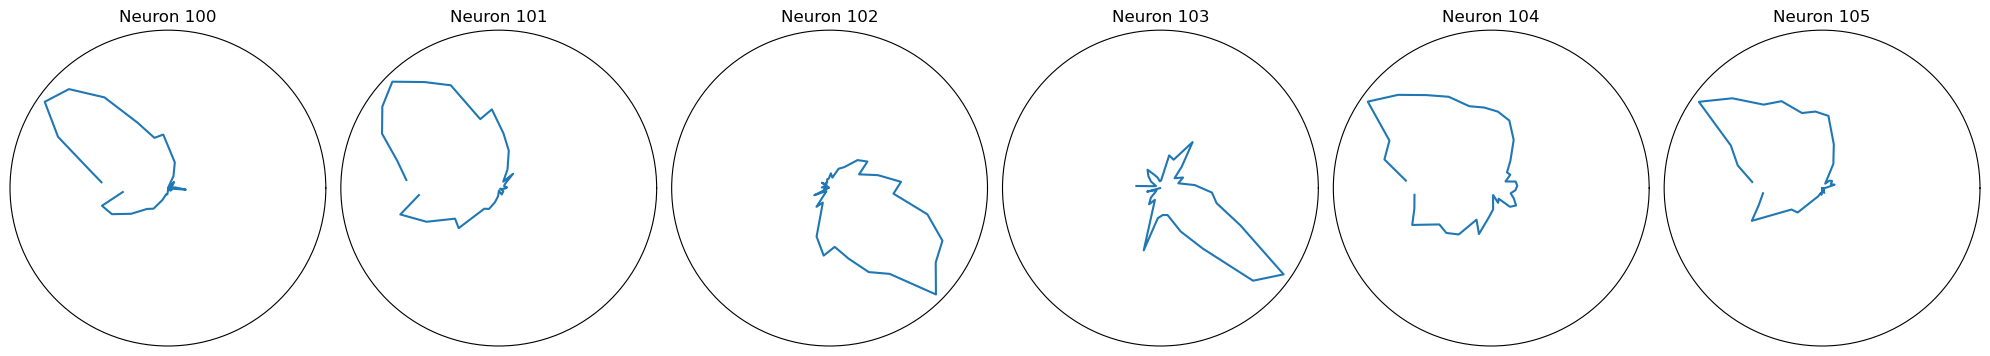

In [133]:
selected_neuron_idxs_hd = [19, 82, 117, 168, 233, 363]
fig, axes = plt.subplots(1, 6, figsize=(20, 4), subplot_kw={'projection': 'polar'})
for i, ax in tqdm(enumerate(axes.flat)):
    ax.plot(bin_centers, hd_tuning_curves[selected_neuron_idxs_hd[i]], label=f'Neuron {i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f'Neuron {i+100}')
plt.tight_layout()
plt.savefig('./report_figs/selected_hd_tuning.png', dpi=200)
plt.show()

100it [00:00, 4060.39it/s]


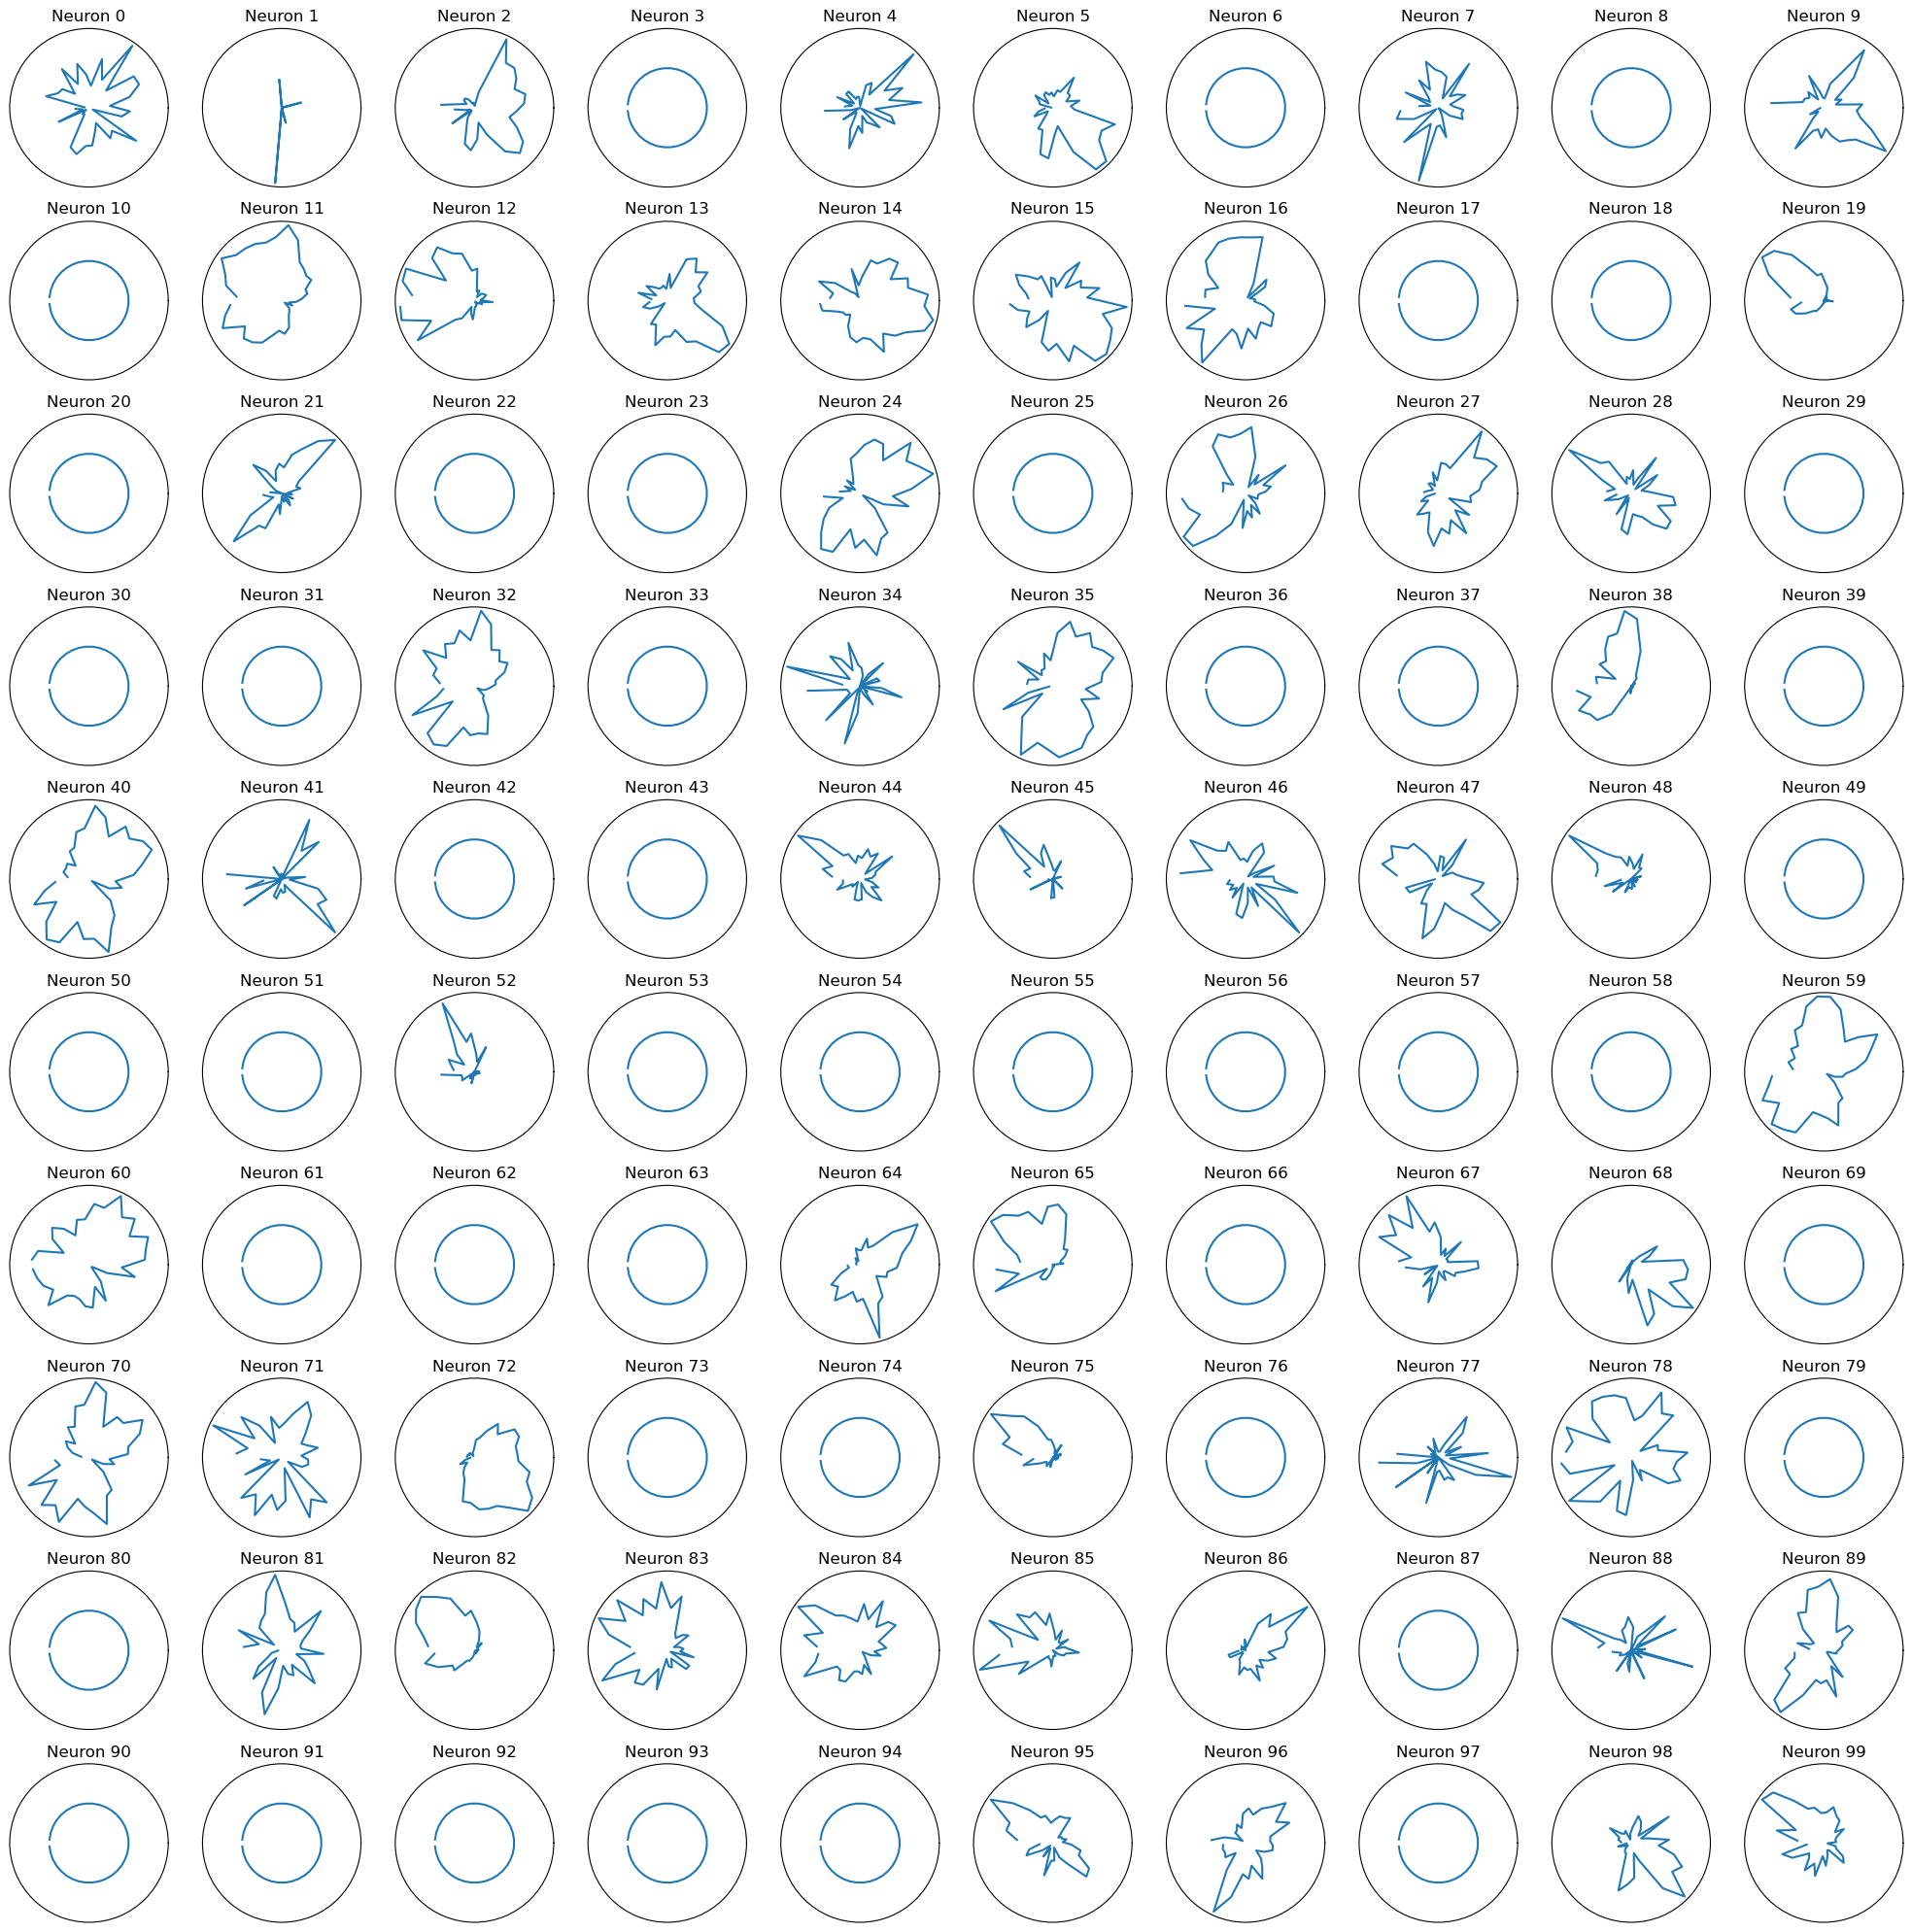

100it [00:00, 4338.29it/s]


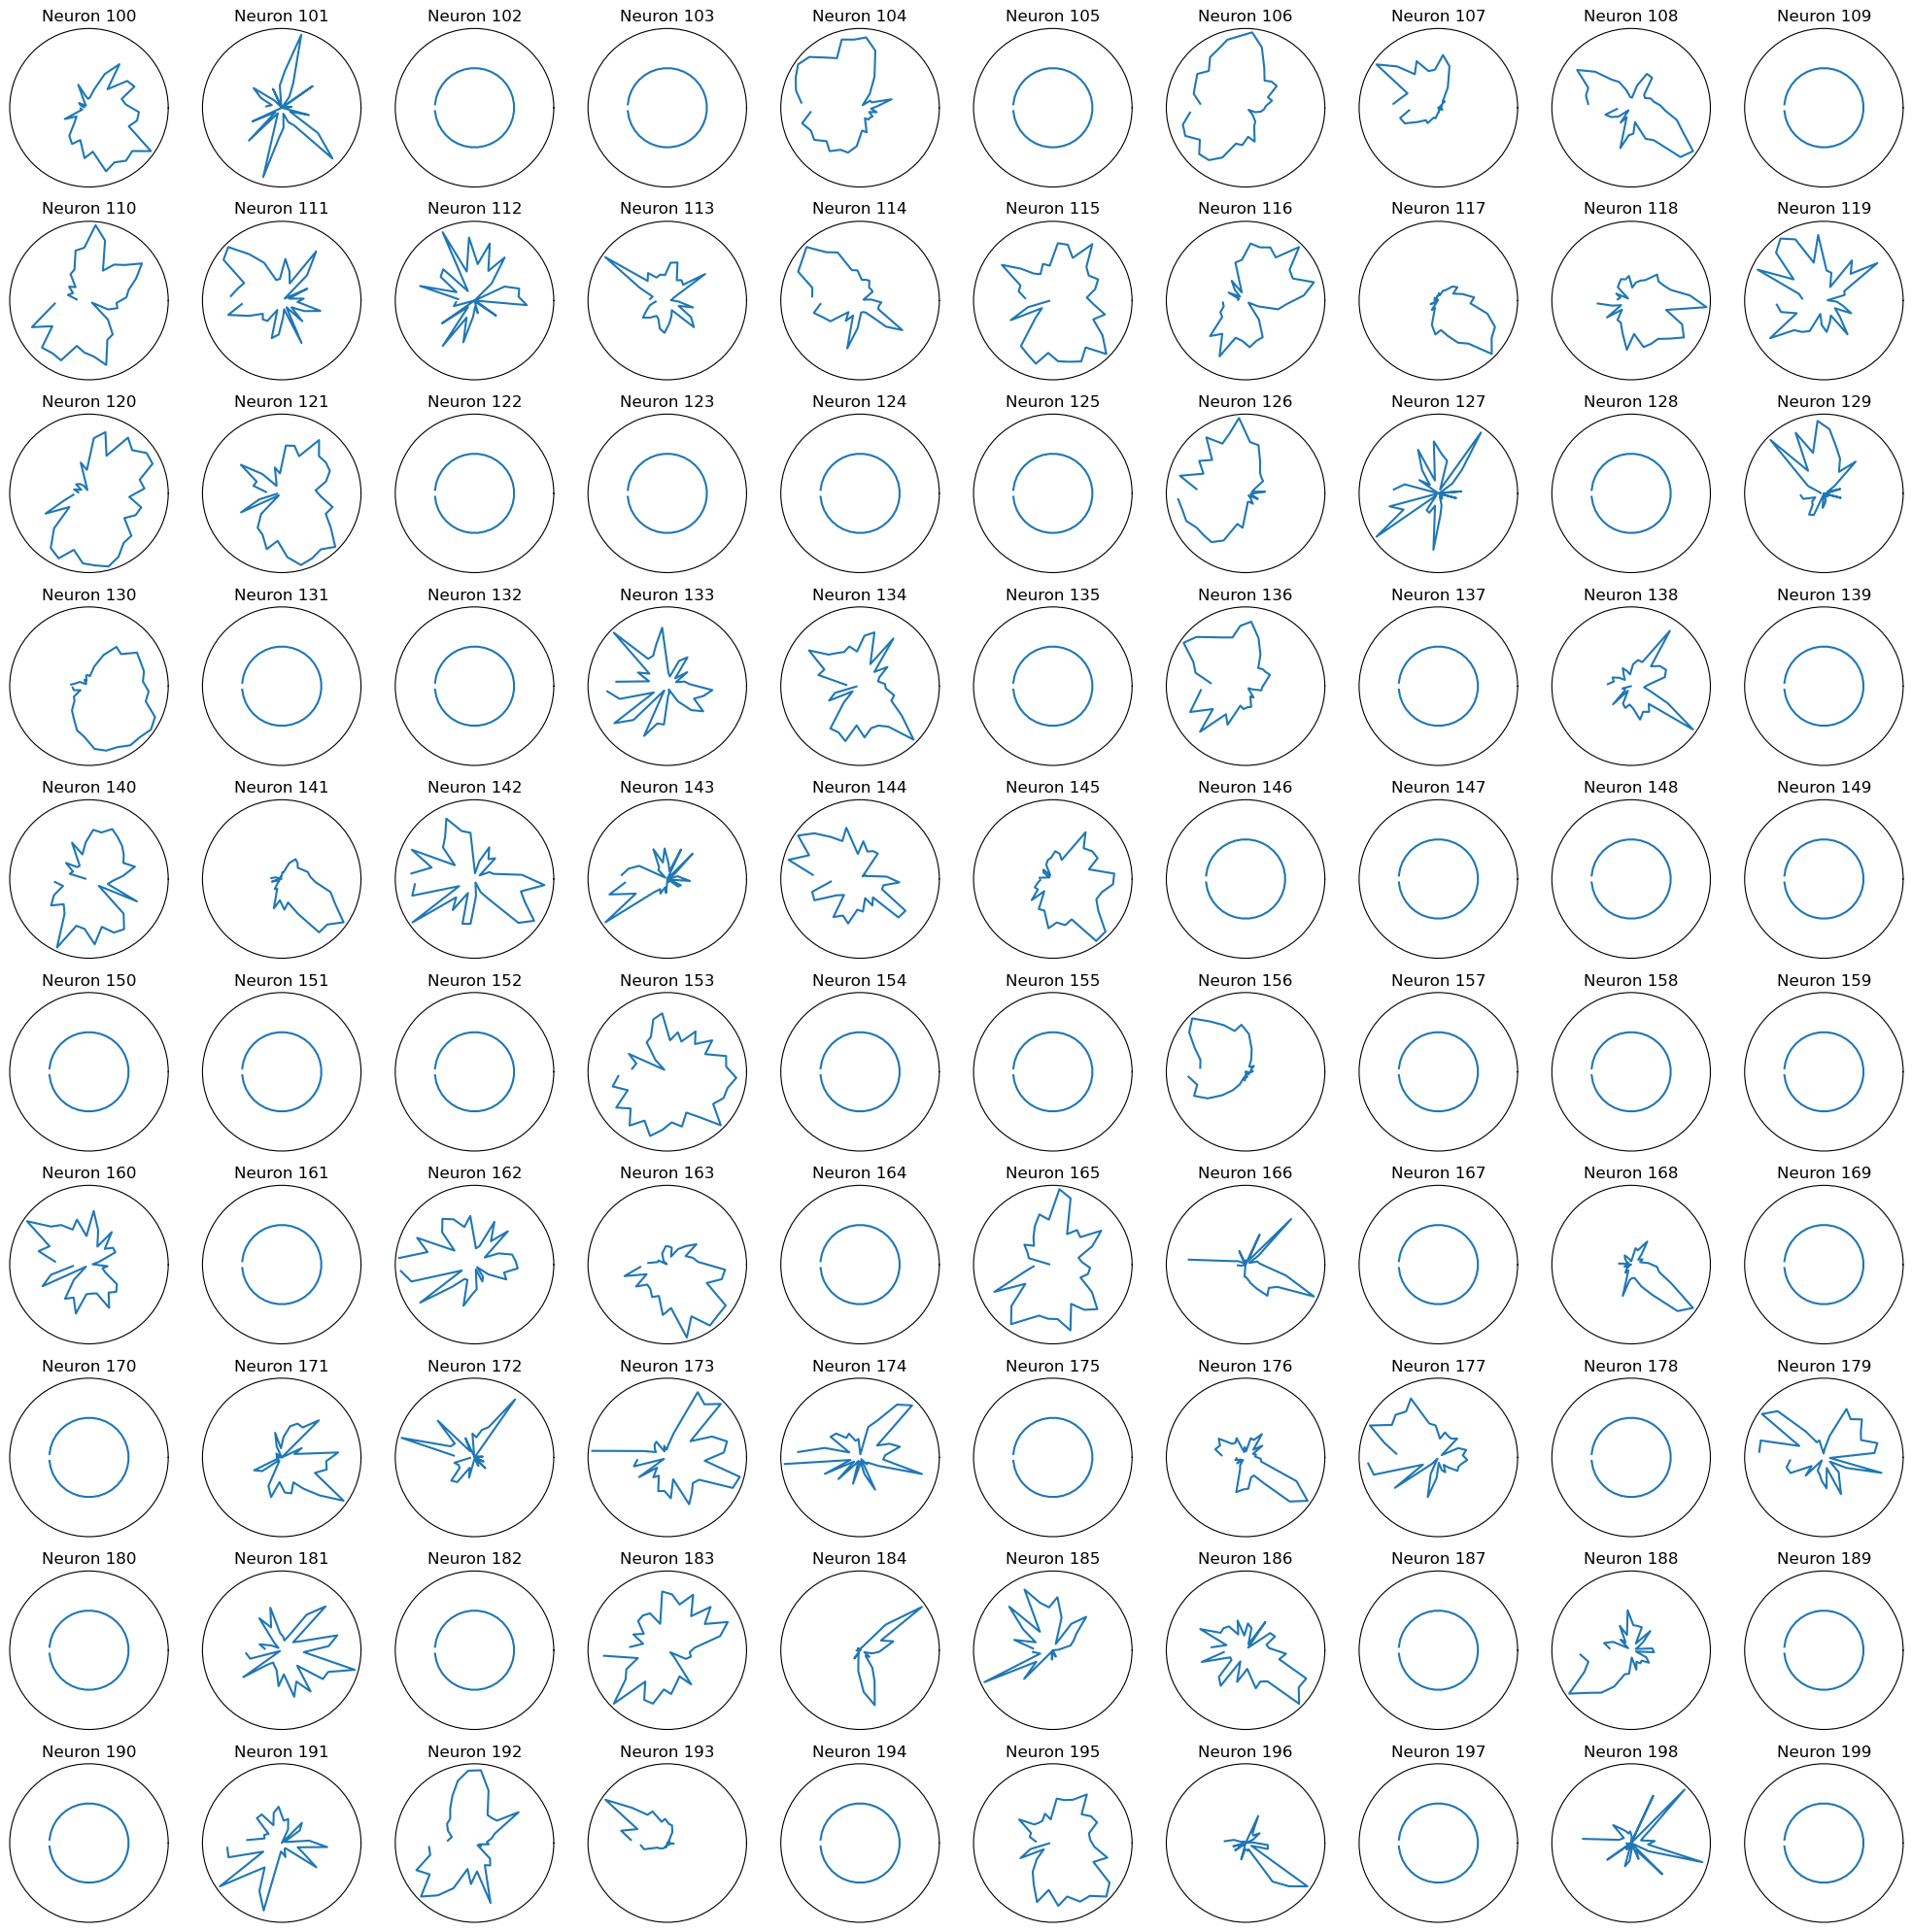

In [53]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20), subplot_kw={'projection': 'polar'})
for i, ax in tqdm(enumerate(axes.flat)):
    ax.plot(bin_centers, hd_tuning_curves[i], label=f'Neuron {i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f'Neuron {i}')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(10, 10, figsize=(20, 20), subplot_kw={'projection': 'polar'})
for i, ax in tqdm(enumerate(axes.flat)):
    ax.plot(bin_centers, hd_tuning_curves[i+100], label=f'Neuron {i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f'Neuron {i+100}')
plt.tight_layout()
plt.show()

100it [00:00, 3843.86it/s]


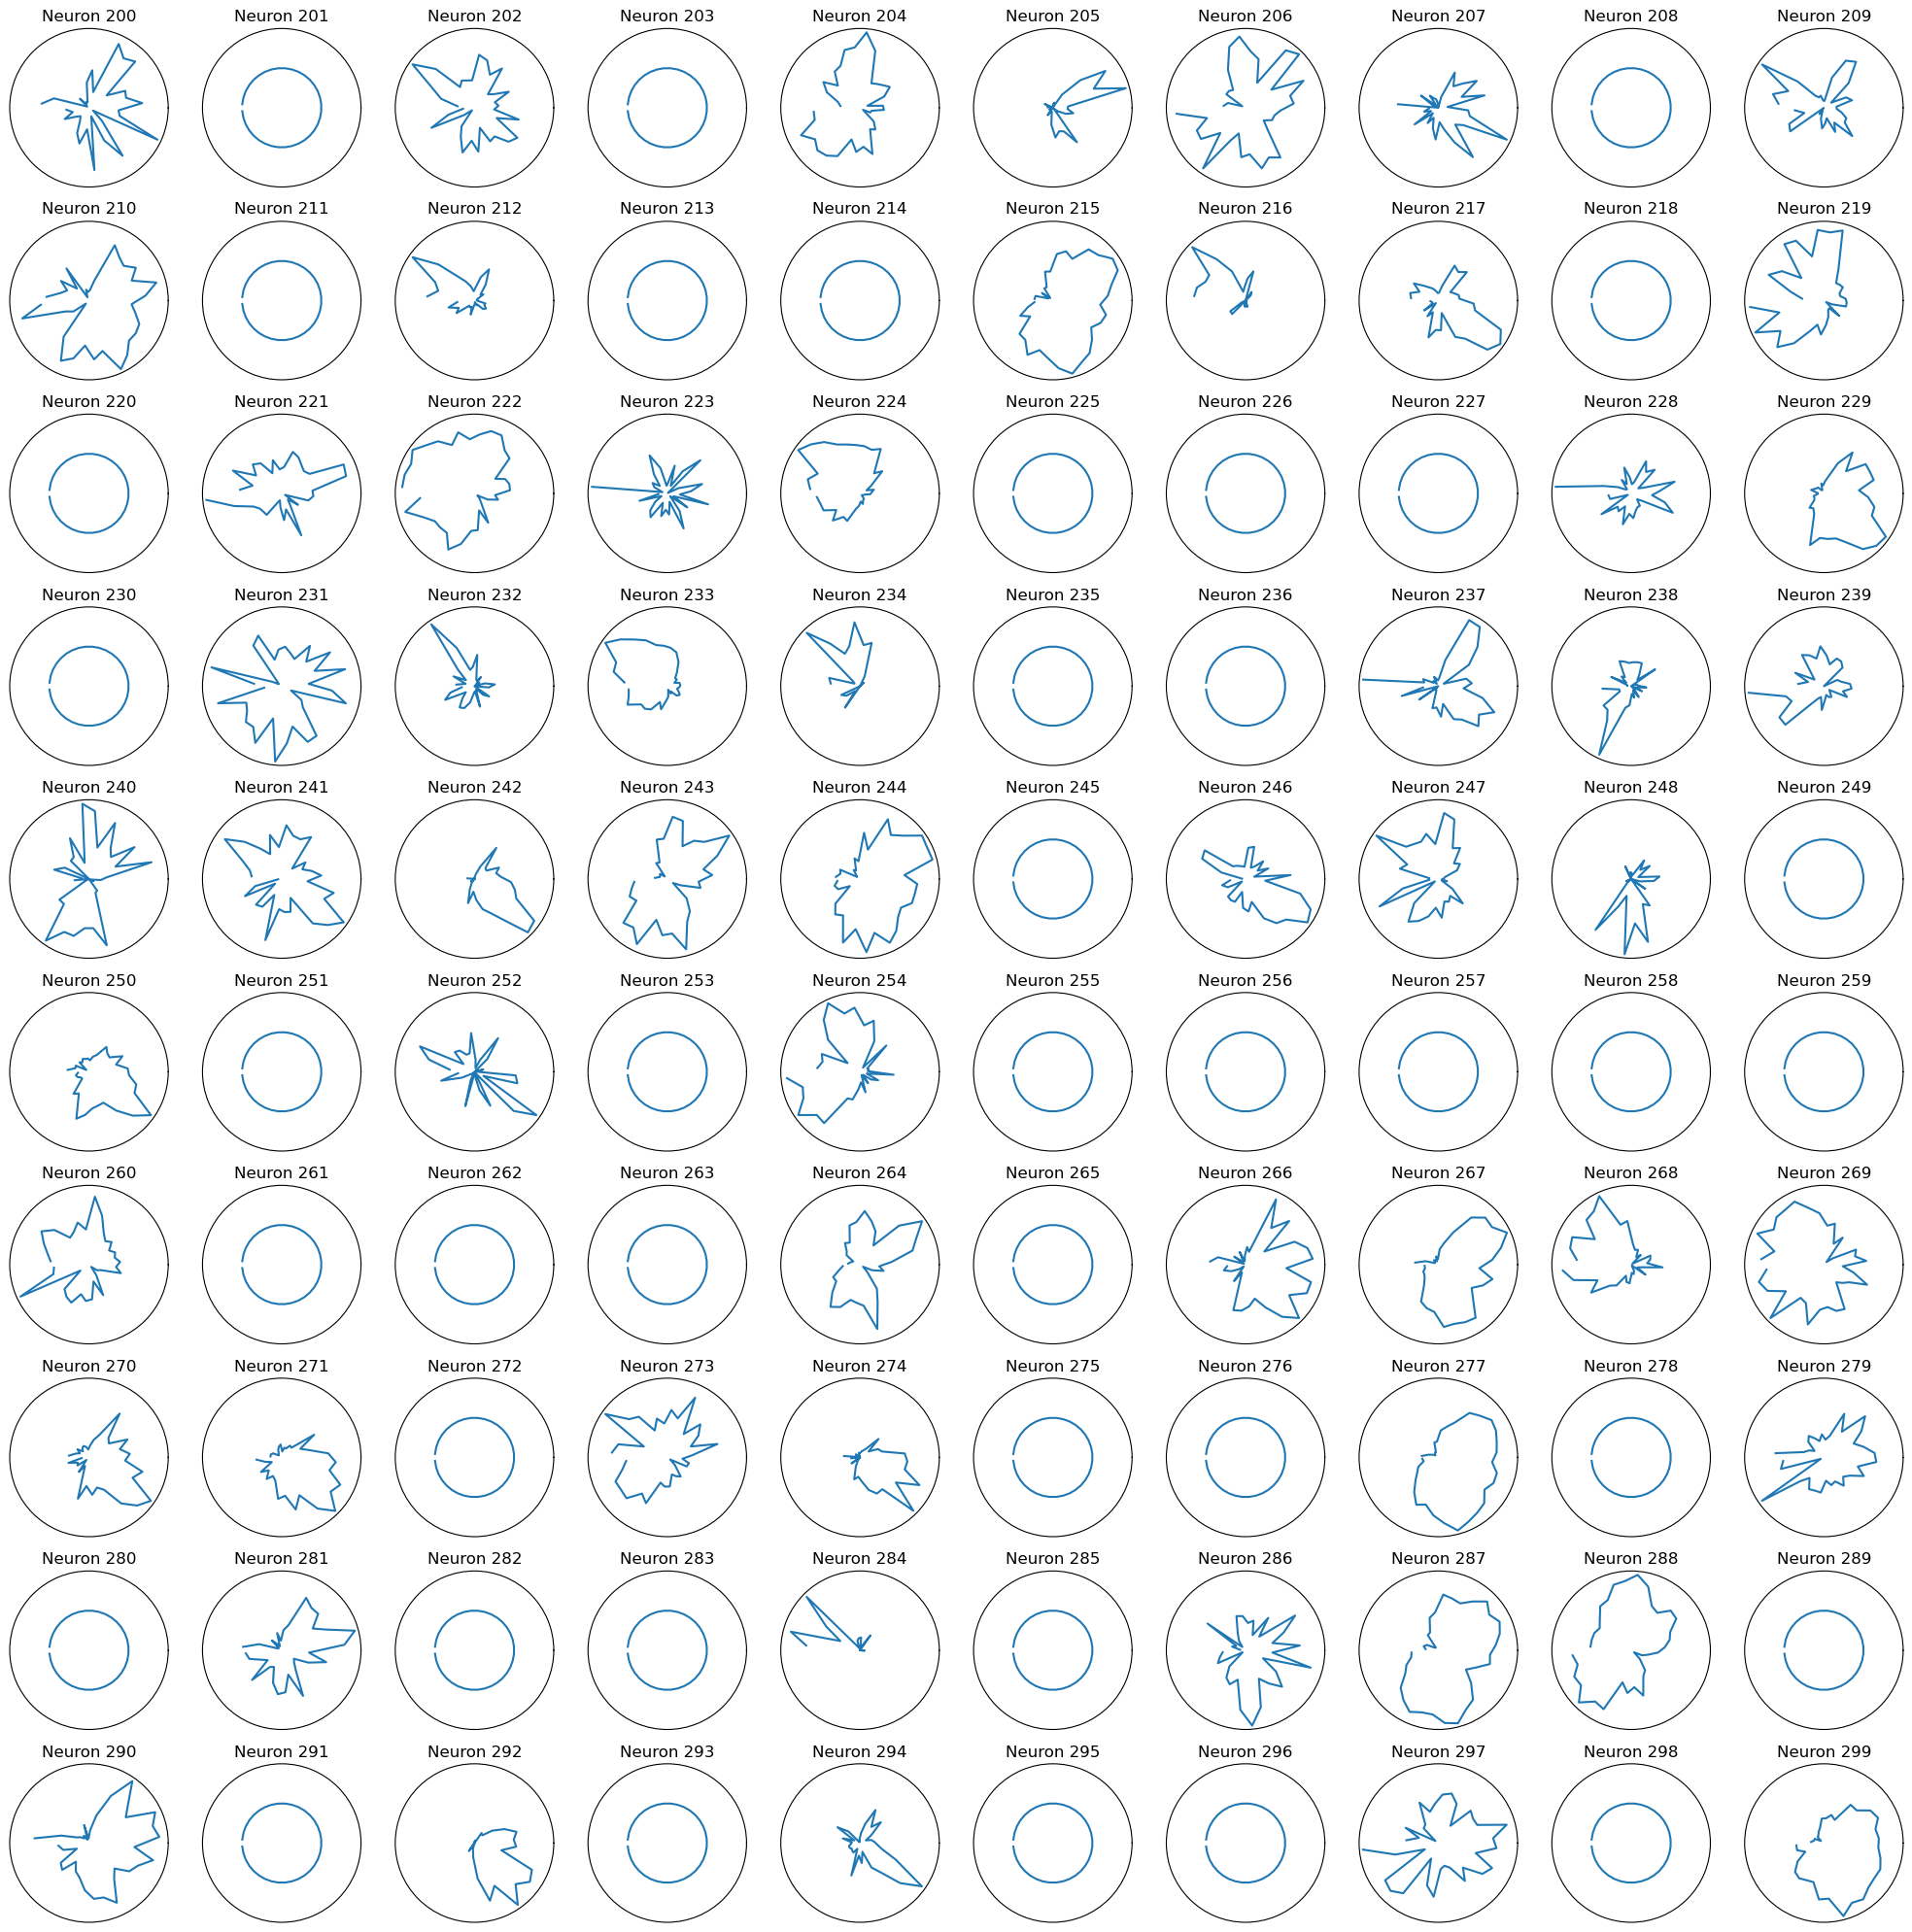

100it [00:00, 4642.28it/s]


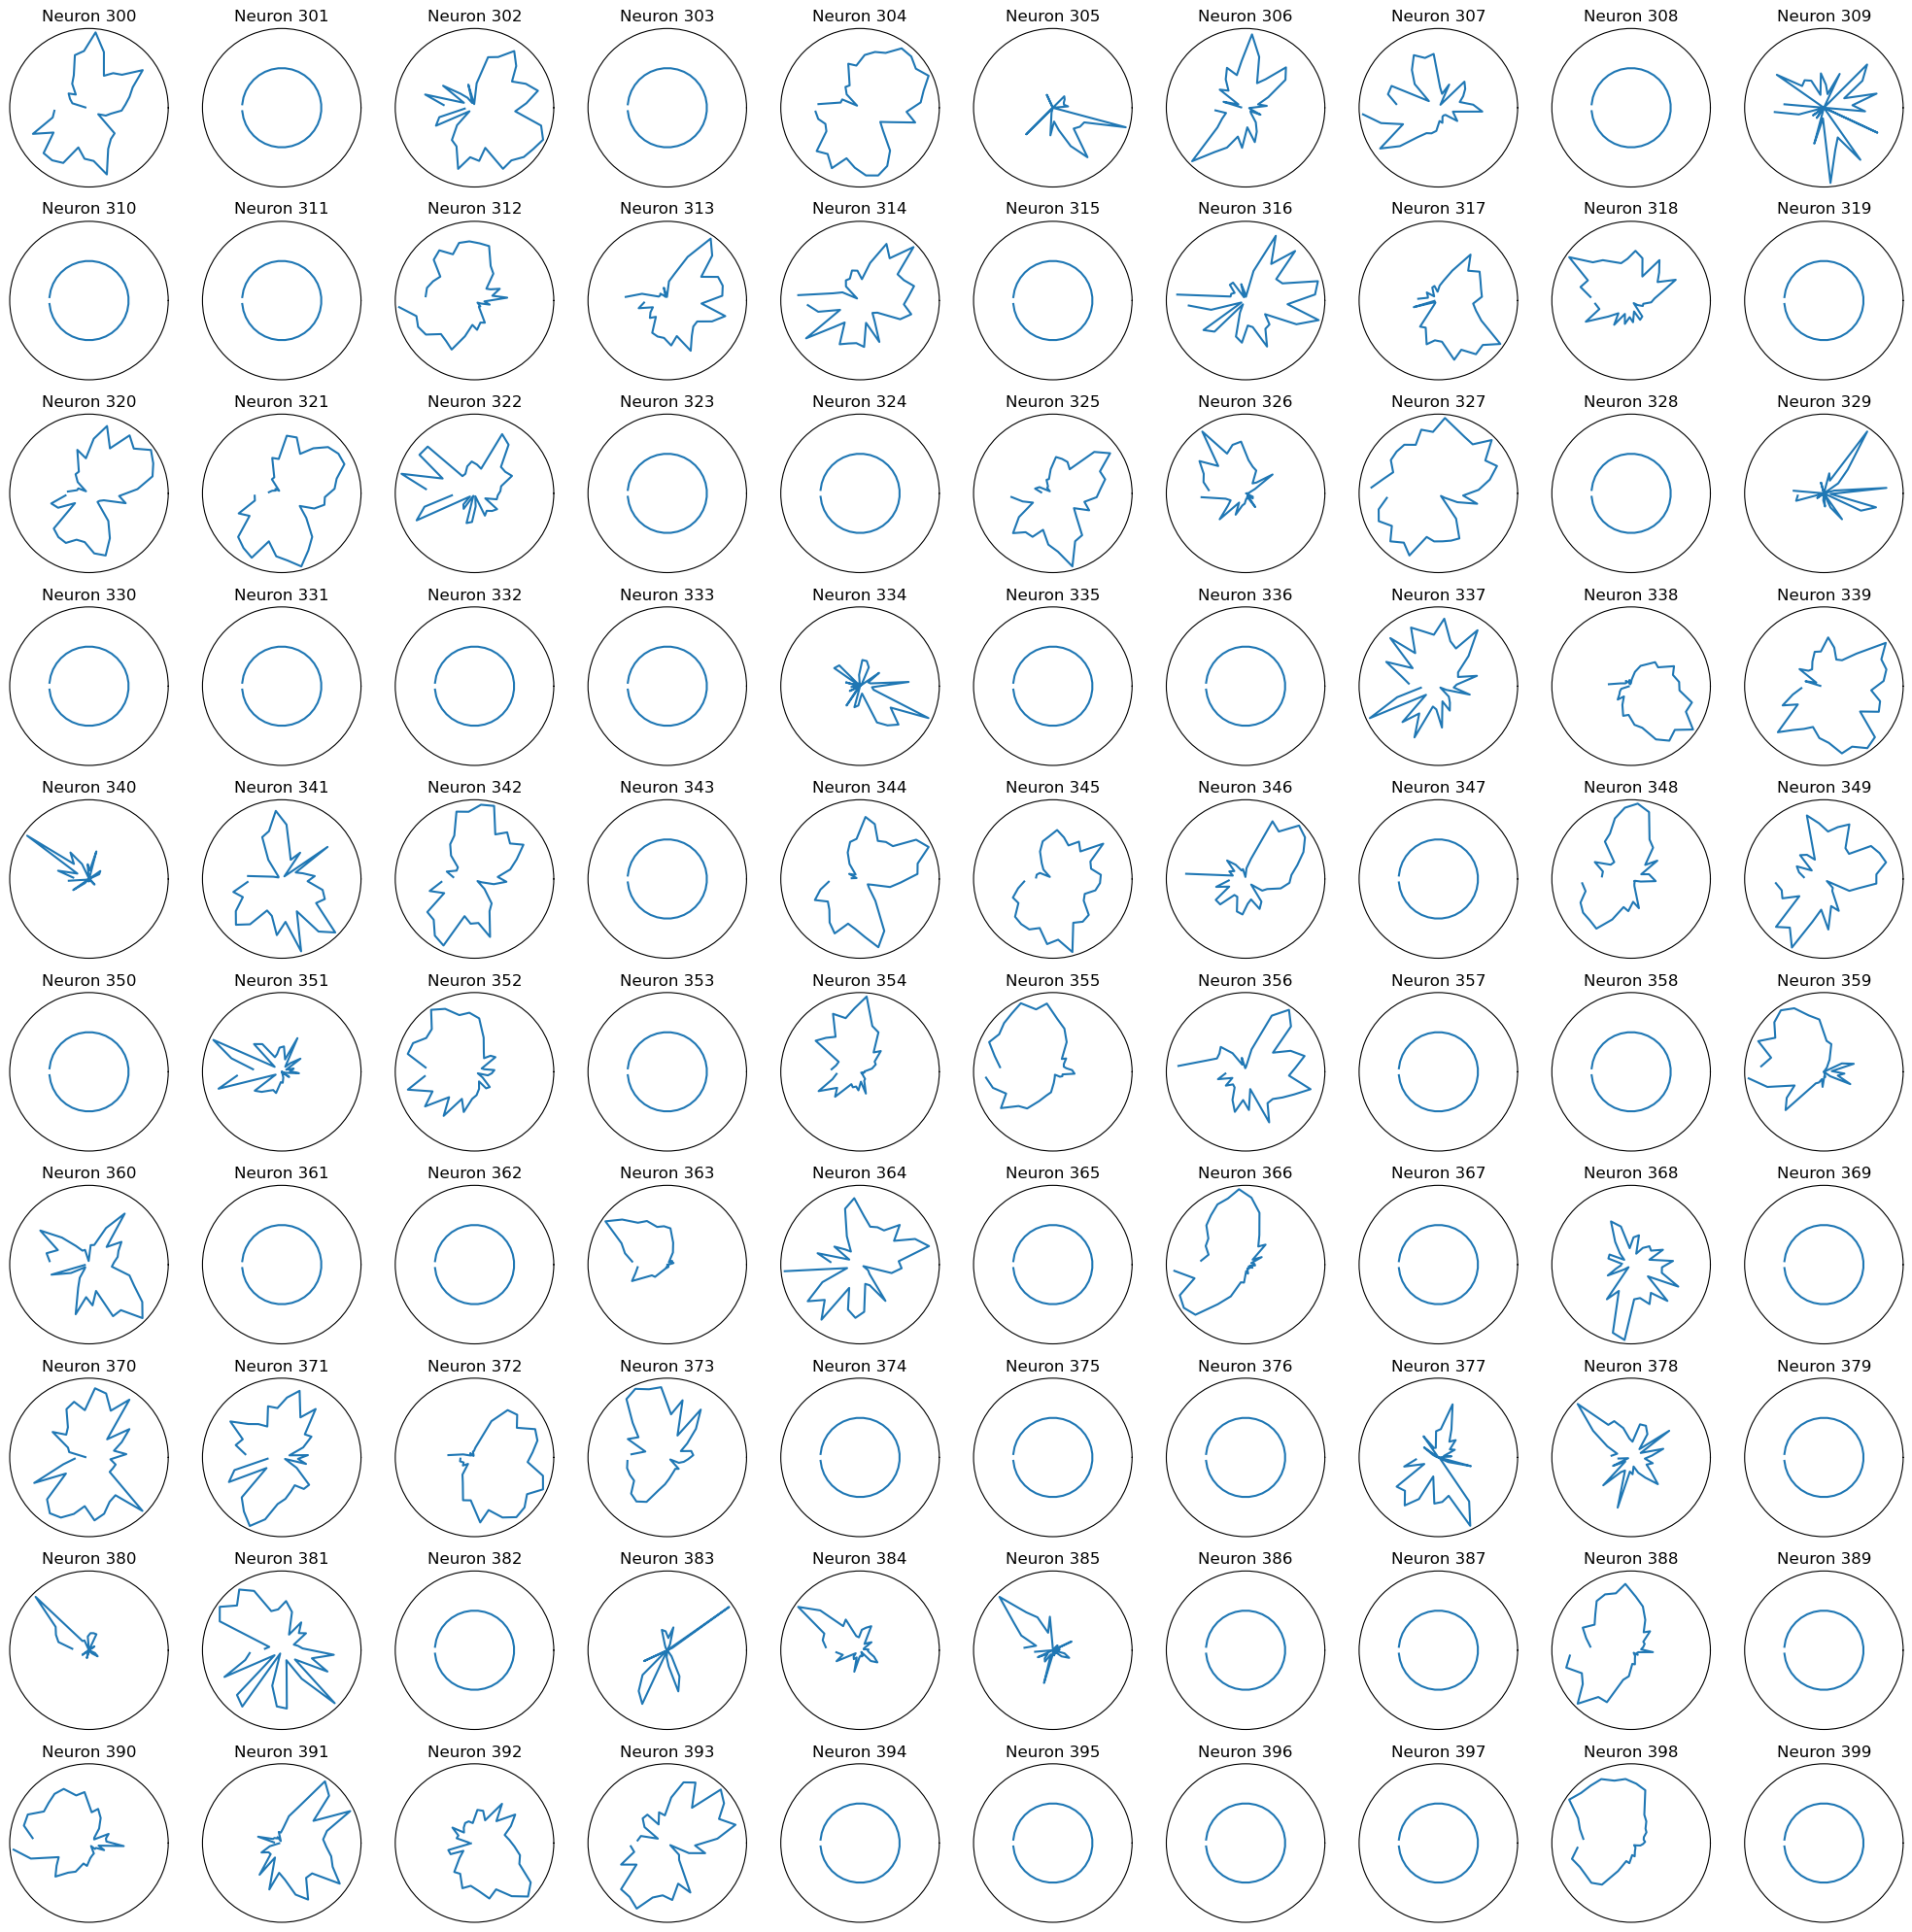

In [54]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20), subplot_kw={'projection': 'polar'})
for i, ax in tqdm(enumerate(axes.flat)):
    ax.plot(bin_centers, hd_tuning_curves[i+200], label=f'Neuron {i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f'Neuron {i+200}')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(10, 10, figsize=(20, 20), subplot_kw={'projection': 'polar'})
for i, ax in tqdm(enumerate(axes.flat)):
    ax.plot(bin_centers, hd_tuning_curves[i+300], label=f'Neuron {i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f'Neuron {i+300}')
plt.tight_layout()
plt.show()

### weights analysis

In [69]:
rnn_weights = {}
with torch.no_grad():
    for name, param in integration_module.named_parameters():
        if name[:3] == 'rnn':
            print(name, param.mean().item(), param.std().item(), param.shape)
            rnn_weights[name] = param.cpu().numpy()

rnn.weight_ih_l0 -0.0006198677001520991 0.03868444636464119 torch.Size([400, 403])
rnn.weight_hh_l0 -0.00034742013667710125 0.03557099774479866 torch.Size([400, 400])
rnn.bias_ih_l0 0.0007334413821808994 0.029818834736943245 torch.Size([400])
rnn.bias_hh_l0 -0.0011430596932768822 0.03097444586455822 torch.Size([400])


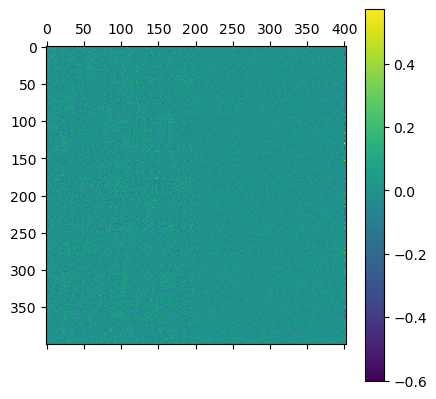

In [67]:
plt.matshow(rnn_weights['rnn.weight_ih_l0'])
plt.colorbar()


In [126]:
standardised_rnn_input_weights = (rnn_weights['rnn.weight_ih_l0'] - rnn_weights['rnn.weight_ih_l0'].mean(0)) / rnn_weights['rnn.weight_ih_l0'].std(0)
normalised_rnn_input_weights = (rnn_weights['rnn.weight_ih_l0'] - rnn_weights['rnn.weight_ih_l0'].min(0)) / (rnn_weights['rnn.weight_ih_l0'].max(0) - rnn_weights['rnn.weight_ih_l0'].min(0))

In [122]:
rnn_weights['rnn.bias_ih_l0'].shape

(400,)

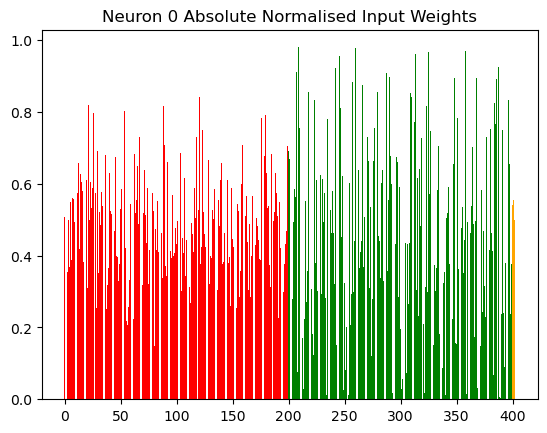

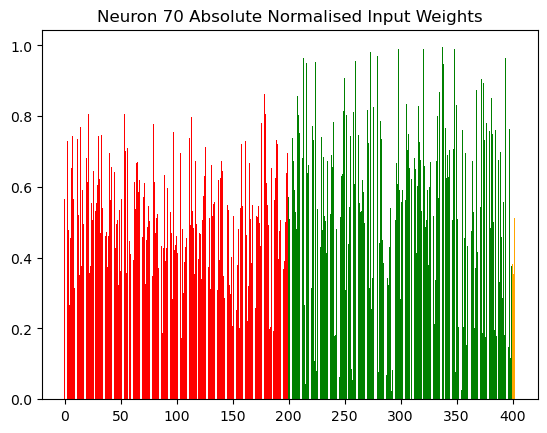

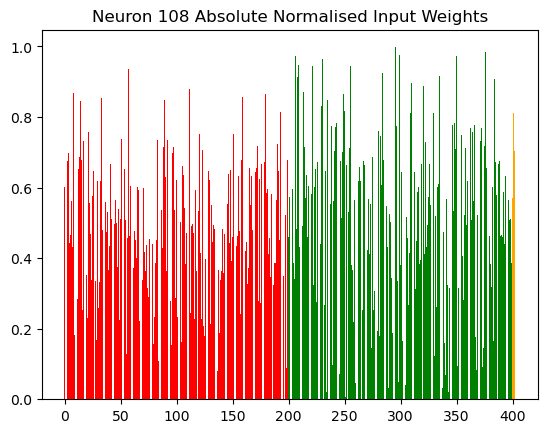

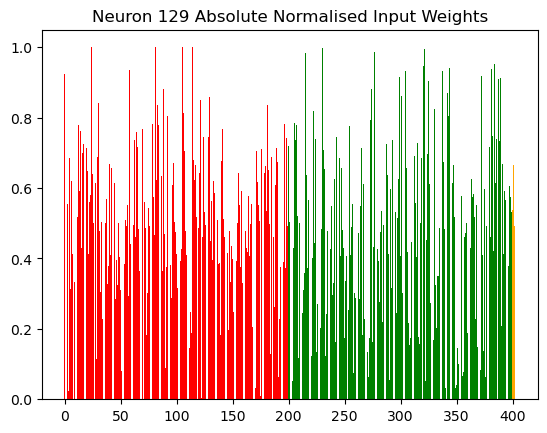

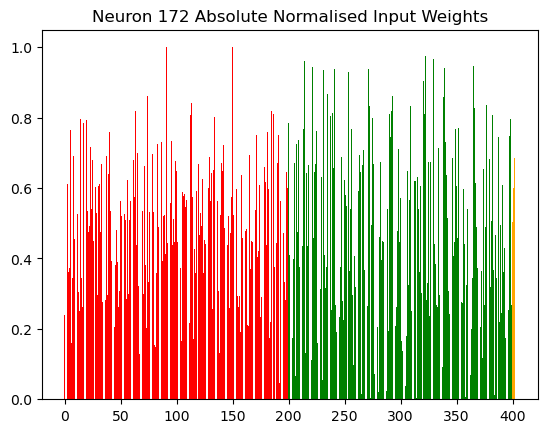

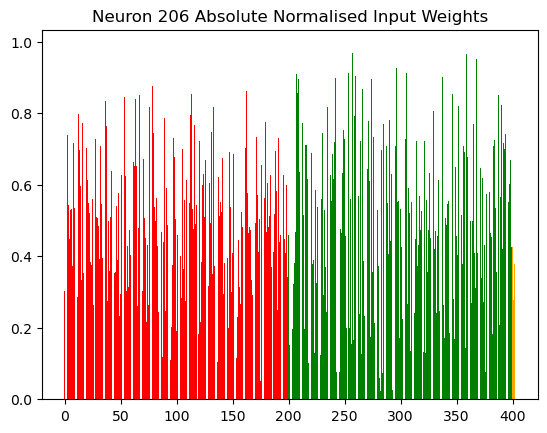

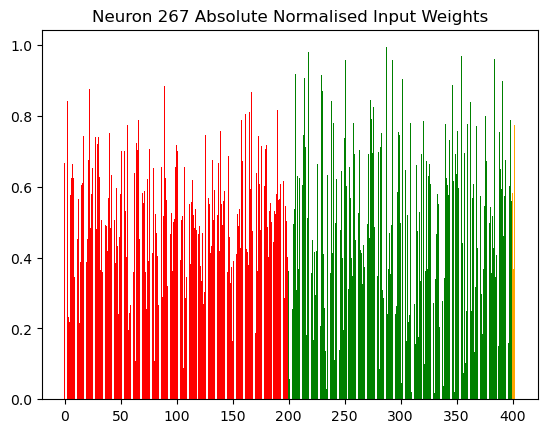

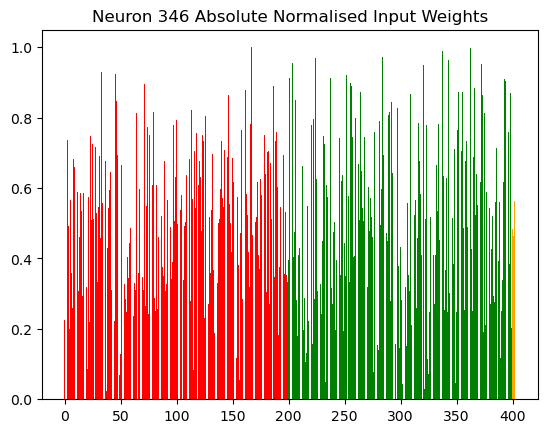

In [128]:
c = ['r' for _ in range(200)] + ['g' for _ in range(200)] + ['orange' for _ in range(3)]
for i, neuron in enumerate(selected_neuron_idxs):
    plt.figure()
    plt.bar(np.arange(rnn_weights['rnn.weight_ih_l0'].shape[1]), normalised_rnn_input_weights[neuron] , color=c)
    plt.title(f'Neuron {neuron} Absolute Normalised Input Weights')
    plt.show()

In [89]:
normalised_rnn_input_w.shape

(400, 403)

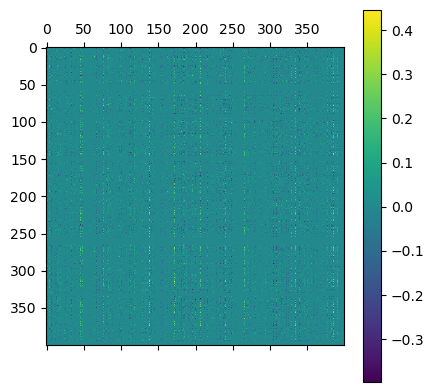

In [68]:
plt.matshow()
plt.colorbar()